# Tugas Besar 1 IF3270 Pembelajaran Mesin Feedforward Neural Network

### Activation Function


In [1]:
import numpy as np

def tanh(x):
    return np.tanh(x)

def softmax(x):
    e = np.exp(np.clip(x, -100, 100))
    return e / np.sum(e, axis=1, keepdims=True)

def linear(x):
    return x

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def swish(x):
    return x / (1 + np.exp(-x))

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

### Function Derivative

In [2]:
# turunan fungsi aktivasi
def linearDerivative(net):
    return 1

def tanDerivative(net):
    return  1 - np.tanh(net) ** 2

def softmaxDerivative(net):
    net = np.array(net)

    softmax_output = np.exp(np.clip(net, -100, 100))
    softmax_output /= np.sum(softmax_output, keepdims=True)

    softmax_jacobian = np.zeros((len(net), len(net)))

    for i in range(len(net)):
        for j in range(len(net)):
            if i == j:
                softmax_jacobian[i, j] = softmax_output[i] * (1 - softmax_output[j])
            else:
                softmax_jacobian[i, j] = -softmax_output[i] * softmax_output[j]
    return softmax_jacobian


def sigmoidDerivative(net):
    net = np.array(net)
    return net * (1 - net)

def reluDerivative(net):
    net = np.array(net)
    return np.where(net > 0, 1, 0)

def eluDerivative(net, a=1.0):
    net = np.array(net)
    return np.where(net > 0, 1, elu(net, a) + a)

def swishDerivative(net):
    net = np.array(net)
    s = swish(net)
    return s + (1 - s) * (1 / (1 + np.exp(-net)))

# turunan fungsi loss
def mseDerivative(o, target):
    o = np.array(o)
    batch_size, num_neurons = o.shape
    target = np.array(target).T

    return (o - target) * 2/batch_size

def binaryDerivative(o, target):
    o = np.array(o)
    target = np.array(target).T
    batch_size, num_neurons = o.shape
    return (o - target)/(o*(1-o)) * 1/batch_size

def categoricalDerivative(o, target):
    o = np.array(o)
    target = np.array(target).T
    batch_size, num_neurons = o.shape
    return -(target / o) * (1 / batch_size)

# hitung gradien
def outputLayer(o, net, target, activFunc, LossFunc):
    if LossFunc == "binary":
        loss =  binaryDerivative(o, target)
    elif LossFunc == "categorical":
        loss = categoricalDerivative(o, target)
    else:
        loss =  mseDerivative(o, target)

    if activFunc=="softmax":
        net = np.array(net).T
        delta = []
        for i in range(len(net)):
            jacobian = softmaxDerivative(net[i])
            delta.append(np.dot(loss[i], jacobian).tolist())

        return delta
    elif activFunc =="tanh":
        return loss * tanDerivative(net).T
    elif activFunc == "sigmoid":
        return loss * sigmoidDerivative(net).T
    elif activFunc == "relu":
        return loss * reluDerivative(net).T
    elif activFunc == "swish":
        return loss * swishDerivative(net).T
    elif activFunc == "elu":
        return loss * eluDerivative(net).T
    else:
        return loss * linearDerivative(net)


def hiddenLayer(w, net, delta, activFunc):
    if activFunc=="softmax":
        dot = np.dot(w, delta)
        delta = []
        for i in range(len(dot)):
            jacobian = softmaxDerivative(net[i])
            delta.append(np.dot(dot[i], jacobian).tolist())
        return delta

    elif activFunc =="tanh":
        return np.dot(w, delta) * tanDerivative(net)
    elif activFunc == "sigmoid":
        return np.dot(w, delta) * sigmoidDerivative(net)
    elif activFunc == "relu":
        return np.dot(w, delta) * reluDerivative(net)
    elif activFunc == "elu":
        return np.dot(w, delta) * eluDerivative(net)
    elif activFunc == "swish":
        return np.dot(w, delta) * swishDerivative(net)
    else:
        return np.dot(w, delta) * linearDerivative(net)


### Layer Model

In [3]:
import numpy as np

class Layers:
    def __init__(self, n_inputs: int, n_neurons: int, activ_func, use_bias=1):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.activ_func = activ_func
        self.use_bias = use_bias

        self.weight = np.random.randn((n_inputs + use_bias), n_neurons)


### RMSNorm

In [4]:
import numpy as np

class RMSNorm:
    def __init__(self, d: int, epsilon: float = 1e-8):
        self.epsilon = epsilon
        self.gamma = np.ones(d)

    def forward(self, x: np.ndarray) -> np.ndarray:
        rms = np.sqrt(np.mean(x ** 2, axis=-1, keepdims=True) + self.epsilon)
        return (x / rms) * self.gamma


### FFNN Model

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import sys
import time

class FFNN:
    def __init__(self, batch_size: int, learning_rate: float, epoch: int, verbose: int, loss_func, weight_init, seed=int, regularization= None, reg_lambda = 0.01, norm = False):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.verbose = verbose
        self.loss_func = loss_func
        self.weight_init = weight_init
        self.loss_train_history = []
        self.loss_val_history = []
        self.seed = seed or None
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.norm = norm

        self.input_train: list[list[float]] = []
        self.input_val: list[list[float]] = []
        self.target_train: list[list[float]] = []
        self.target_val: list[list[float]] = []
        self.layers: list[Layers] = []
        self.delta_gradien: list[np.ndarray] = []

    def initDeltaGradien(self):
        self.delta_gradien = [np.zeros((layer.n_inputs+1, layer.n_neurons)) for layer in self.layers]

    def initWeight(self, lower_bound=-0.5, upper_bound=0.5, mean=0.0, variance=1.0):
        if self.weight_init == "custom":
            bxh = np.array([[0.35, 0.35]])
            wxh = np.array([[0.15, 0.25],
                            [0.2, 0.3]])
            self.layers[0].weight = np.vstack((bxh, wxh))
            bhy = np.array([[0.6, 0.6]])
            why = np.array([[0.4, 0.5],
                            [0.45, 0.55]])
            self.layers[1].weight = np.vstack((bhy, why))
        else:
            for layer in self.layers:
                fan_in = layer.n_inputs
                fan_out = layer.n_neurons

                if self.seed is not None:
                    np.random.seed(self.seed)
                if self.weight_init == "zero":
                    layer.weight = np.zeros((layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "uniform":
                    layer.weight = np.random.uniform(low=lower_bound, high=upper_bound, size=(layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "normal":
                    layer.weight = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "xavier":
                    variance_xavier = 2 / (fan_in + fan_out)
                    layer.weight = np.random.normal(loc=0.0, scale=np.sqrt(variance_xavier), size=(layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "he":
                    variance_he = 2 / fan_in
                    layer.weight = np.random.normal(loc=0.0, scale=np.sqrt(variance_he), size=(layer.n_inputs + 1, layer.n_neurons))

    def calcLoss(self, output: list[float], target: list[float]):
        if self.loss_func == "mse":
            return np.mean((np.array(target) - np.array(output)) ** 2)
        elif self.loss_func == "binary":
            output = np.array(output, dtype=np.float64)
            target = np.array(target, dtype=np.float64)
            return -np.mean(target * np.log(output + 1e-9) + (1 - target) * np.log(1 - output))
        elif self.loss_func == "categorical":
            return -np.mean(np.sum(target * np.log(output + 1e-9), axis=1))

        reg_term = 0
        if self.regularization == "l1":
            reg_term = self.reg_lambda * sum(np.sum(np.abs(layer.weight)) for layer in self.layers)

        elif self.regularization == "l2":
            reg_term = self.reg_lambda * sum(np.sum(layer.weight ** 2) for layer in self.layers)

        return loss + reg_term

    def updateWeight(self):
        for idx, layer in enumerate(self.layers):
            reg_term = 0

            if self.regularization == "l1":
                reg_term = self.reg_lambda * np.sign(layer.weight)

            elif self.regularization == "l2":
                reg_term = self.reg_lambda * 2 * layer.weight

            layer.weight -= self.delta_gradien[idx] + reg_term

    def updateGradien(self, layer_idx: int, delta: np.ndarray, input: np.ndarray):
        grad = self.learning_rate * (np.array(input) @ np.array(delta).T)
        self.delta_gradien[layer_idx] = grad


    def addInputTarget(self, input_train: list[float], input_val: list[float], target_train: list[float], target_val: list[float]):
        self.input_train.append(input_train)
        self.input_val.append(input_val)
        self.target_train.append(target_train)
        self.target_val.append(target_val)

    def addHiddenLayer(self, layer: Layers):
        self.layers.append(layer)

    def plot_weight_distribution(self, layers_to_plot: list[int] = None):
        if layers_to_plot is None:
            layers_to_plot = list(range(len(self.layers)))

        num_layers = len(layers_to_plot)
        fig, ax = plt.subplots(1, num_layers, figsize=(5 * num_layers, 4), sharey=True)

        if num_layers == 1:
            ax = [ax]

        for i, layer_idx in enumerate(layers_to_plot):
            if layer_idx < 0 or layer_idx >= len(self.layers):
                print(f"Layer {layer_idx+1} tidak valid.")
                continue

            weights = self.layers[layer_idx].weight.flatten()
            ax[i].hist(weights, bins=30, alpha=0.7, color='b', edgecolor='black')
            ax[i].set_title(f'Layer {layer_idx+1}')
            ax[i].set_xlabel('Nilai Bobot')
            ax[i].set_ylabel('Frekuensi')
            ax[i].grid(True, linestyle='--', alpha=0.6)

        plt.suptitle('Distribusi Bobot Per Layer', fontsize=14)
        plt.tight_layout()
        plt.show()


    def plot_gradient_distribution(self, layers_to_plot: list[int] = None):
        if layers_to_plot is None:
            layers_to_plot = list(range(len(self.delta_gradien)))

        num_layers = len(layers_to_plot)
        fig, ax = plt.subplots(1, num_layers, figsize=(5 * num_layers, 4), sharey=True)

        if num_layers == 1:
            ax = [ax]

        for i, layer_idx in enumerate(layers_to_plot):
            if layer_idx < 0 or layer_idx >= len(self.delta_gradien):
                print(f"Layer {layer_idx+1} tidak valid.")
                continue

            grad = self.delta_gradien[layer_idx].flatten()
            ax[i].hist(grad, bins=30, alpha=0.7, color='r', edgecolor='black')
            ax[i].set_title(f'Layer {layer_idx+1}')
            ax[i].set_xlabel('Nilai Gradien')
            ax[i].set_ylabel('Frekuensi')
            ax[i].grid(True, linestyle='--', alpha=0.6)

        plt.suptitle('Distribusi Gradien Per Layer', fontsize=14)
        plt.tight_layout()
        plt.show()

    def feedForward(self):
        self.initWeight()
        start_time = time.time()
        self.loss_train_history = []
        self.loss_val_history = []

        for j in range(self.epoch):
            self.initDeltaGradien()
            train_error = 0
            epoch_start_time = time.time()

            for i, batch in enumerate(self.input_train):
                inputs: list[list[float]] = []
                nets: list[list[float]] = []
                self.initDeltaGradien()

                batch = np.array(batch)
                batch_size = batch.shape[0]
                bias = np.ones((batch_size, 1))
                current = np.hstack((bias, batch))
                inputs.append(current.copy().transpose().tolist())

                for layer in self.layers:
                    net = np.dot(current, layer.weight)
                    current = layer.activ_func(net)
                    if self.norm == True:
                        current = RMSNorm(layer.n_neurons).forward(current)
                    nets.append(net.copy().transpose().tolist())
                    if layer != self.layers[-1]:
                        bias = np.ones((batch_size, 1))
                        current = np.hstack((bias, current))
                    inputs.append(current.copy().transpose().tolist())

                train_error += self.calcLoss(current, self.target_train[i])
                self.backPropagation(inputs, nets, self.target_train[i])
                self.updateWeight()

            self.loss_train_history.append(train_error)
            val_pred = self.predict(self.input_val)
            val_error = self.calcLoss(val_pred, self.target_val)
            self.loss_val_history.append(val_error)

            epoch_duration = time.time() - epoch_start_time
            total_elapsed = time.time() - start_time
            estimated_total_time = (total_elapsed / (j + 1)) * self.epoch
            eta = estimated_total_time - total_elapsed

            if self.verbose == 1:
                bar_length = 30
                progress = (j + 1) / self.epoch
                bar = "=" * int(bar_length * progress) + "-" * (bar_length - int(bar_length * progress))
                sys.stdout.write(f"\rEpoch {j+1}/{self.epoch} [{bar}] {progress*100:.1f}% - Training Loss: {train_error:.4f} - Validation Loss: {val_error:.4f} - {epoch_duration:.2f}s/epoch - ETA: {eta:.2f}s")
                sys.stdout.flush()

        print("\n         Training History          ")
        print("==================================")
        print("Epoch | Train Loss | Val Loss")
        print("-----------------------------------")
        for epoch, (train_loss, val_loss) in enumerate(zip(self.loss_train_history, self.loss_val_history)):
            print(f"{epoch+1:5d} |  {train_loss:.6f}  | {val_loss:.6f}")
        print("===================================")


    def backPropagation(self, inputs, netsLayer, target):
        # print(f"Total layers : {len(self.layers)}")
        i = len(self.layers) - 1
        delta1: np.ndarray = None

        while i >= -1:
            nets = np.array(netsLayer[i]).T

            if i == len(self.layers) - 1:  # Output layer
                if self.layers[i].activ_func == softmax:
                    delta1 = outputLayer(inputs[i+1], nets, target,"softmax",self.loss_func)
                elif self.layers[i].activ_func == tanh:
                    delta1 = outputLayer(inputs[i+1], nets, target,"tanh",self.loss_func)
                elif self.layers[i].activ_func == sigmoid:
                    delta1 = outputLayer(inputs[i+1], nets, target,"sigmoid",self.loss_func)
                elif self.layers[i].activ_func == relu:
                    delta1 = outputLayer(inputs[i+1], nets, target,"relu",self.loss_func)
                elif self.layers[i].activ_func == elu:
                    delta1 = outputLayer(inputs[i+1], nets, target,"elu",self.loss_func)
                elif self.layers[i].activ_func == swish:
                    delta1 = outputLayer(inputs[i+1], nets, target,"swish",self.loss_func)
                else: # linear
                    delta1 = outputLayer(inputs[i+1], nets, target,"linear",self.loss_func)

            else:  # Hidden layer
                # print("LAYERR",self.layers[i + 1].weight)
                if self.layers[i].activ_func == softmax:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "softmax")
                elif self.layers[i].activ_func == tanh:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "tanh")
                elif self.layers[i].activ_func == sigmoid:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "sigmoid")
                elif self.layers[i].activ_func == relu:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "relu")
                elif self.layers[i].activ_func == swish:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "swish")
                elif self.layers[i].activ_func == elu:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "elu")
                else: # linear
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "linear")

                self.updateGradien(i + 1, delta1,inputs[i+1])

                # print(f"Current input: {inputs[i+1][1:]}")
                # print(f"Current delta1: {delta1}")
                # print(f"Current All gradien: {self.delta_gradien}")
                # print(f"Current gradien: {self.delta_gradien[i + 1]}")
                delta1 = delta2

            i -= 1

    @staticmethod
    def visualize_network(ffnn):
        G = nx.DiGraph()
        layer_labels = []
        positions = {}

        for i in range(len(ffnn.input_train[0][0])):
            G.add_node(f"Input {i+1}")
            positions[f"Input {i+1}"] = (0, -i)
            layer_labels.append(f"Input {i+1}")

        prev_layer_neurons = [f"Input {i+1}" for i in range(len(ffnn.input_train[0][0]))]
        x_pos = 1

        for idx, layer in enumerate(ffnn.layers):
            current_layer_neurons = []
            bias_node = f"Bias {idx+1}"
            positions[bias_node] = (x_pos - 0.5, layer.n_neurons / 3)
            G.add_node(bias_node)
            layer_labels.append(bias_node)

            for n in range(layer.n_neurons):
                neuron_name = f"Layer {idx+1}\nNeuron {n+1}"
                G.add_node(neuron_name)
                current_layer_neurons.append(neuron_name)
                positions[neuron_name] = (x_pos, -n)
                layer_labels.append(neuron_name)

                weight_bias = layer.weight[0][n]
                gradient_bias = ffnn.delta_gradien[idx][0][n]
                G.add_edge(bias_node, neuron_name, weight=f"W: {weight_bias:.2f}\nG: {gradient_bias:.2f}")

                for prev_neuron in prev_layer_neurons:
                    weight_idx = prev_layer_neurons.index(prev_neuron) + 1
                    weight = layer.weight[weight_idx][n]
                    gradient = ffnn.delta_gradien[idx][weight_idx][n]
                    G.add_edge(prev_neuron, neuron_name, weight=f"W: {weight:.2f}\nG: {gradient:.2f}")

            prev_layer_neurons = current_layer_neurons
            x_pos += 1

        plt.figure(figsize=(12, 8))
        nx.draw(G, positions, with_labels=True, node_color='pink', node_size=1000, font_size=10, font_color='darkblue')

        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels, font_color='red', label_pos=0.25)

        plt.title("Feed Forward Neural Network Visualization (Weights & Gradients)")
        plt.show()

    def save_model(self, filename):
        model_data = {
            "layers": [layer.weight for layer in self.layers],
            "batch_size": self.batch_size,
            "learning_rate": self.learning_rate,
            "epoch": self.epoch,
            "loss_func": self.loss_func
        }
        with open(filename, "wb") as f:
            pickle.dump(model_data, f)
        print(f"Model berhasil disimpan ke {filename}")

    def load_model(self, filename):
        with open(filename, "rb") as f:
            model_data = pickle.load(f)

        if len(model_data["layers"]) != len(self.layers):
            raise ValueError("Jumlah layer pada model yang dimuat tidak sesuai.")

        for layer, weight in zip(self.layers, model_data["layers"]):
            layer.weight = weight

        self.batch_size = model_data["batch_size"]
        self.learning_rate = model_data["learning_rate"]
        self.epoch = model_data["epoch"]
        self.loss_func = model_data["loss_func"]

        print(f"Model berhasil dimuat dari {filename}")

    def plot_loss(self):
        plt.figure(figsize=(4, 2))
        plt.plot(self.loss_train_history, label='Training Loss', color='blue')
        plt.plot(self.loss_val_history, label='Validation Loss', color='red', linestyle='dashed')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training & Validation Loss', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


    def predict(self, X):
        batch = np.array(X)
        if batch.ndim == 3:
            batch = batch.reshape(batch.shape[1], batch.shape[2])

        batch_size = batch.shape[0]
        bias = np.ones((batch_size, 1))
        current = np.hstack((bias, batch))

        for layer in self.layers:
            net = np.dot(current, layer.weight)
            current = layer.activ_func(net)
            if layer != self.layers[-1]:
                bias = np.ones((batch_size, 1))
                current = np.hstack((bias, current))
        return current


## Model Analysis

In [6]:
import numpy as np
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pickle

def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

# Load dataset MNIST
print("Loading MNIST dataset...")
t0 = time.time()
train_samples = 5000
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='auto')
y = y.astype(int)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=10000)
y_train_oh = one_hot_encode(y_train)
y_test_oh = one_hot_encode(y_test)
print(f"Data loaded in {time.time() - t0:.2f} seconds.")


Loading MNIST dataset...
Data loaded in 5.93 seconds.


In [7]:
def train_ffnn(depth, width, learning_rate, activation, weight_init, norm=False, regularization=None):
    ffnn = FFNN(batch_size=train_samples, learning_rate=learning_rate, epoch=20, verbose=1, loss_func='mse', weight_init=weight_init, seed=42, norm=norm, regularization=regularization)

    for _ in range(depth - 1):
        ffnn.addHiddenLayer(Layers(n_inputs=784 if _ == 0 else width, n_neurons=width, activ_func=activation))

    output_layer = Layers(n_inputs=width, n_neurons=10, activ_func=tanh)
    ffnn.addHiddenLayer(output_layer)

    ffnn.addInputTarget(X_train.tolist(), X_test, y_train_oh.tolist(), y_test_oh.tolist())
    ffnn.feedForward()
    ffnn.plot_loss()
    ffnn.plot_weight_distribution()
    ffnn.plot_gradient_distribution()

    y_pred = ffnn.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    accuracy = np.mean(y_pred_labels == y_test) * 100

    return ffnn, accuracy

### Pengaruh depth (banyak layer) dan width (banyak neuron per layer)


 Width 50 Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.3169 - Validation Loss: 0.2470 - 1.70s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.395064  | 0.513210
    2 |  0.510023  | 0.396687
    3 |  0.390697  | 0.386024
    4 |  0.384803  | 0.334973
    5 |  0.332446  | 0.336084
    6 |  0.336466  | 0.318001
    7 |  0.314168  | 0.275864
    8 |  0.270681  | 0.301120
    9 |  0.298509  | 0.555022
   10 |  0.548461  | 0.295261
   11 |  0.288478  | 0.287709
   12 |  0.282444  | 0.296277
   13 |  0.291178  | 0.331482
   14 |  0.328489  | 0.396708
   15 |  0.394541  | 0.261479
   16 |  0.253242  | 0.612048
   17 |  0.607678  | 0.513855
   18 |  0.514024  | 0.339889
   19 |  0.332760  | 0.320374
   20 |  0.316889  | 0.246955


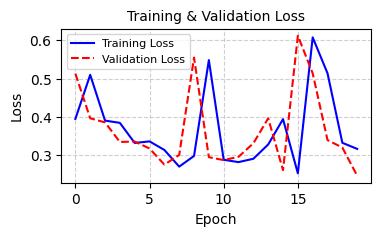

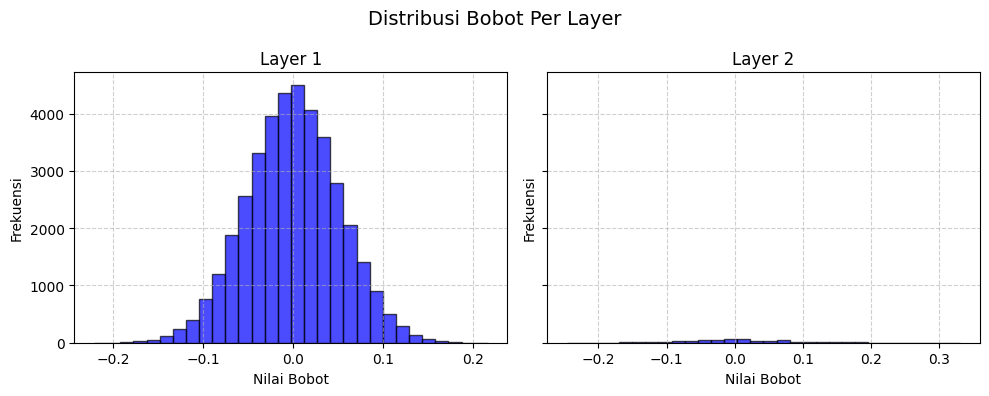

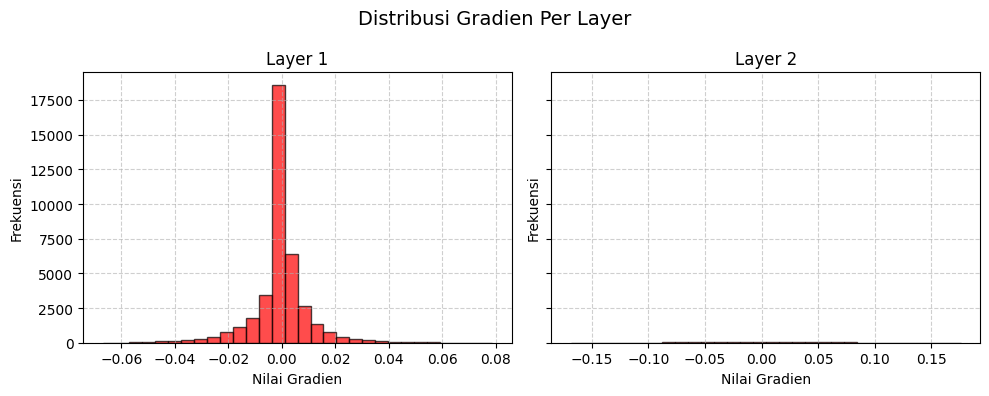


 Width 100 Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.5905 - Validation Loss: 0.8100 - 2.10s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.407086  | 0.578735
    2 |  0.580890  | 0.480137
    3 |  0.483065  | 0.476330
    4 |  0.474644  | 0.397306
    5 |  0.391444  | 0.482596
    6 |  0.478558  | 0.337691
    7 |  0.336816  | 0.413317
    8 |  0.409401  | 0.309833
    9 |  0.299379  | 0.230789
   10 |  0.227175  | 0.314609
   11 |  0.307912  | 0.320288
   12 |  0.315270  | 0.398744
   13 |  0.395243  | 0.389515
   14 |  0.384899  | 0.591205
   15 |  0.586423  | 0.287938
   16 |  0.285562  | 0.253697
   17 |  0.249547  | 0.244736
   18 |  0.240981  | 0.287785
   19 |  0.290667  | 0.587207
   20 |  0.590510  | 0.810000


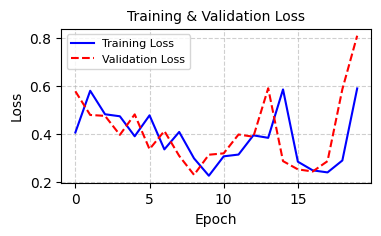

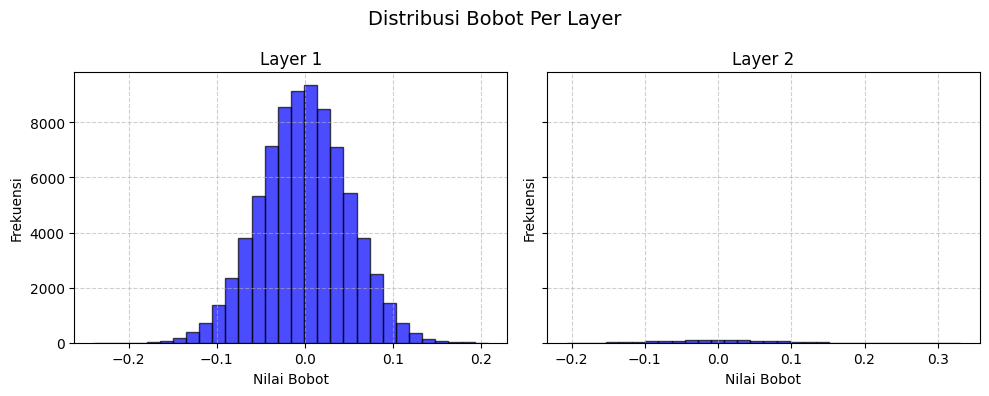

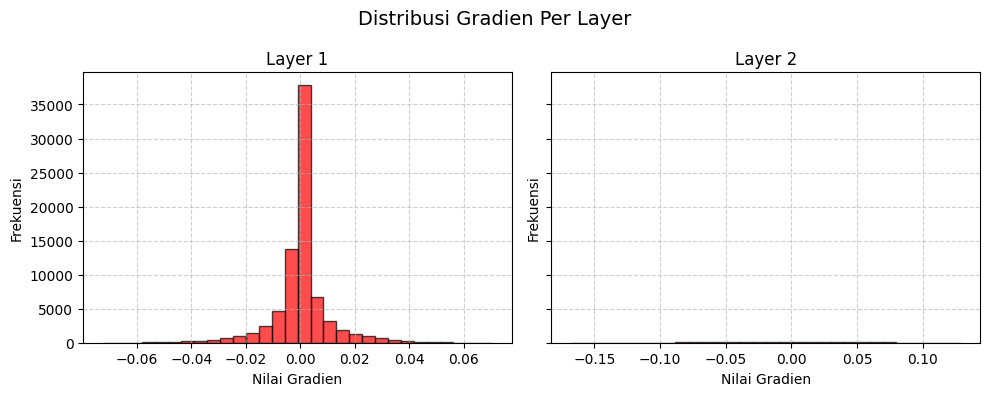


 Width 200 Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.6540 - Validation Loss: 0.5205 - 2.20s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.430902  | 0.683296
    2 |  0.684724  | 0.607212
    3 |  0.607060  | 0.587789
    4 |  0.584319  | 0.567520
    5 |  0.564497  | 0.500867
    6 |  0.501931  | 0.432617
    7 |  0.431302  | 0.445923
    8 |  0.444384  | 0.434910
    9 |  0.433011  | 0.336787
   10 |  0.329124  | 0.321488
   11 |  0.315907  | 0.462862
   12 |  0.456440  | 0.269352
   13 |  0.268769  | 0.287952
   14 |  0.285326  | 0.282422
   15 |  0.281884  | 0.293057
   16 |  0.289536  | 0.353542
   17 |  0.355597  | 0.471530
   18 |  0.468765  | 0.803821
   19 |  0.807219  | 0.652293
   20 |  0.654019  | 0.520536


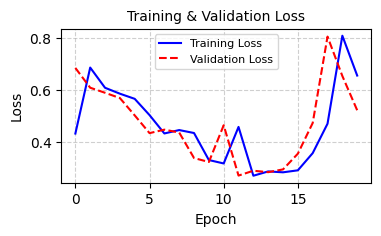

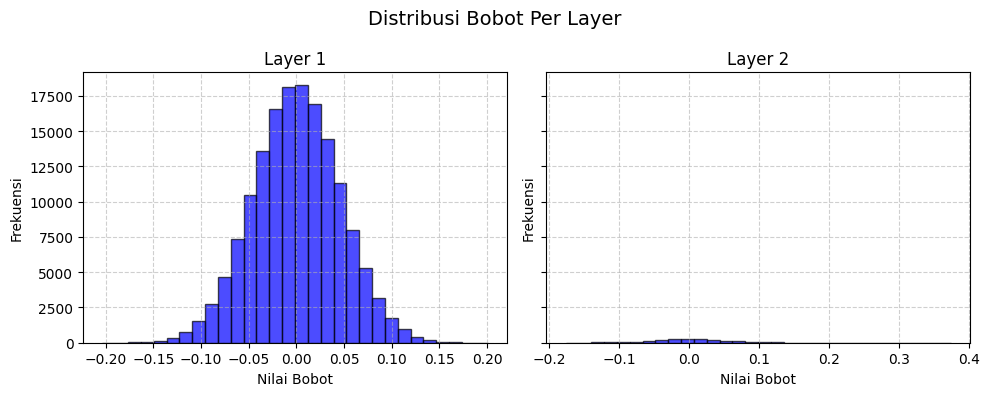

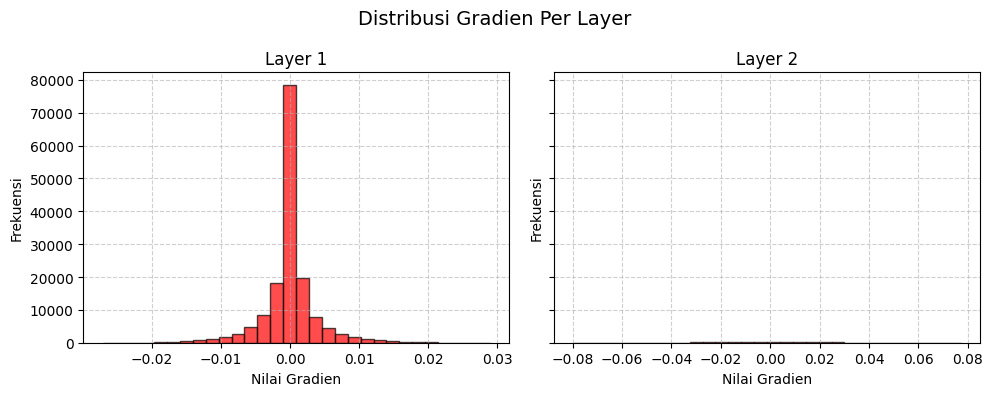

In [8]:
width_var = [50, 100, 200]

results = {}
for width in width_var:
    print(f"\n Width {width} Result\n")
    ffnn, acc = train_ffnn(depth=2, width=width, learning_rate=0.001, activation=tanh, weight_init='xavier')
    results[f"Width {width}"] = acc

Dari hasil pengujian di atas, terlihat bahwa semakin banyak jumlah width-nya (jumlah neuron) maka nilai training loss & validation loss cenderung akan meningkat yang menandakan bahwa model semakin buruk dalam memahami pola pada data. Dengan hasil nilai loss akhir dimulai dari 0.3169, 0.5905 dan 0.6550 untuk percobaan pada width 50, 100, dan 200. Selain itu, width 50 memberikan nilai terbaik, karena ketika width ditingkatkan menjadi 100 dan 200 terlihat bahwa penambahan width memberikan penurunan pada nilai akurasi. Kecenderungan ini membuktikan bahwa terdapat suatu batas efektivitas ketika memperkecil width.

Peninjauan kedua dilakukan terhadap distribusi bobot per layer. Pada width 50, bobot cenderung lebih merata, menunjukkan pembelajaran yang lebih sederhana dan memberikan distribusi bobot yang normal. Sementara itu, pada width 100, distribusi bobot normal, menandakan keseimbangan antara kapasitas model dan stabilitas pembelajaran. Di sisi lain, pada width 200, distribusi bobot semakin tajam dengan variansi besar, yang dapat berisiko menyebabkan eksploding gradients, yaitu saat nilai gradien selama backpropagation menjadi sangat besar yang menyebabkan perubahan bobot yang ekstrem dan ketidakstabilan dalam pelatihan. Sehingga perlu dikendalikan dengan teknik seperti normalisasi bobot atau regulasi yang baik. Oleh karena itu, width 50 memberikan keseimbangan yang baik antara generalisasi dan stabilitas dalam proses pembelajaran.

Peninjauan terakhir dilakukan terhadap distribusi gradien per layer. Pada width 50, distribusi gradien menunjukkan nilai yang relatif kecil dan terpusat di sekitar nol, menandakan bahwa pembelajaran berjalan stabil. Pada width 100, distribusi gradien menjadi lebih tajam dengan variansi yang sangat besar, yang dapat menyebabkan eksploding gradients dan membuat pembelajaran menjadi tidak stabil. Sementara itu, pada width 200, distribusi gradien juga menunjukkan nilai yang relatif kecil dan terpusat di sekitar nol. Oleh karena itu, width 50 menjadi pilihan yang optimal untuk melakukan training pada model.



 Depth 2 Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.3169 - Validation Loss: 0.2470 - 1.80s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.395064  | 0.513210
    2 |  0.510023  | 0.396687
    3 |  0.390697  | 0.386024
    4 |  0.384803  | 0.334973
    5 |  0.332446  | 0.336084
    6 |  0.336466  | 0.318001
    7 |  0.314168  | 0.275864
    8 |  0.270681  | 0.301120
    9 |  0.298509  | 0.555022
   10 |  0.548461  | 0.295261
   11 |  0.288478  | 0.287709
   12 |  0.282444  | 0.296277
   13 |  0.291178  | 0.331482
   14 |  0.328489  | 0.396708
   15 |  0.394541  | 0.261479
   16 |  0.253242  | 0.612048
   17 |  0.607678  | 0.513855
   18 |  0.514024  | 0.339889
   19 |  0.332760  | 0.320374
   20 |  0.316889  | 0.246955


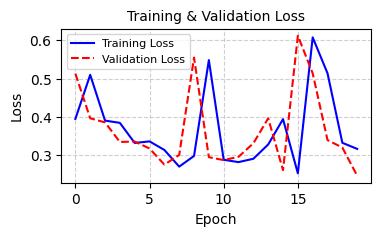

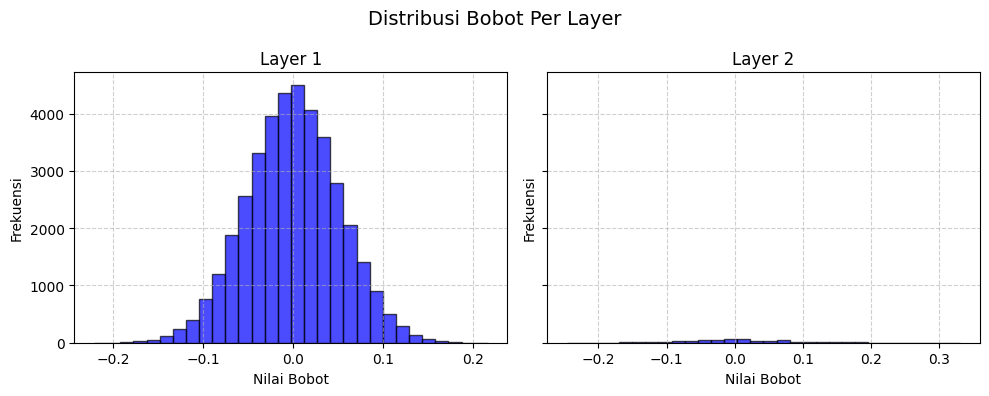

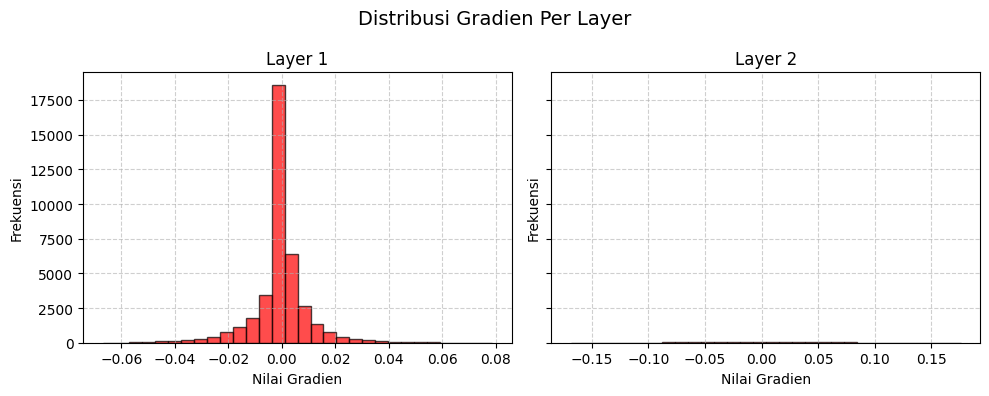


 Depth 4 Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.1300 - Validation Loss: 0.0837 - 2.80s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.292290  | 0.231603
    2 |  0.229650  | 0.401554
    3 |  0.403568  | 0.242153
    4 |  0.239026  | 0.495164
    5 |  0.500224  | 0.350848
    6 |  0.348810  | 0.377542
    7 |  0.378184  | 0.383563
    8 |  0.383867  | 0.525679
    9 |  0.526576  | 0.402631
   10 |  0.400880  | 0.314978
   11 |  0.312278  | 0.282863
   12 |  0.282890  | 0.256542
   13 |  0.260157  | 0.198703
   14 |  0.197115  | 0.173048
   15 |  0.172534  | 0.174200
   16 |  0.172462  | 0.176594
   17 |  0.173913  | 0.136967
   18 |  0.135098  | 0.125989
   19 |  0.124303  | 0.129576
   20 |  0.129950  | 0.083683


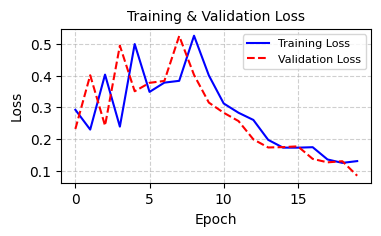

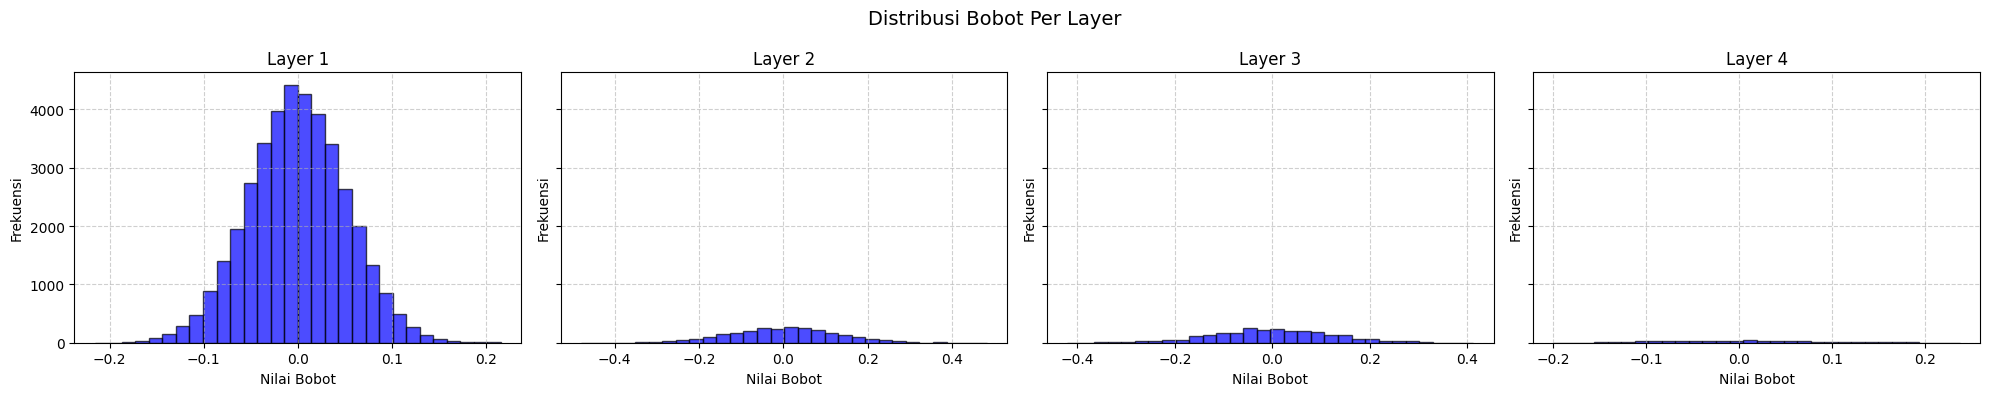

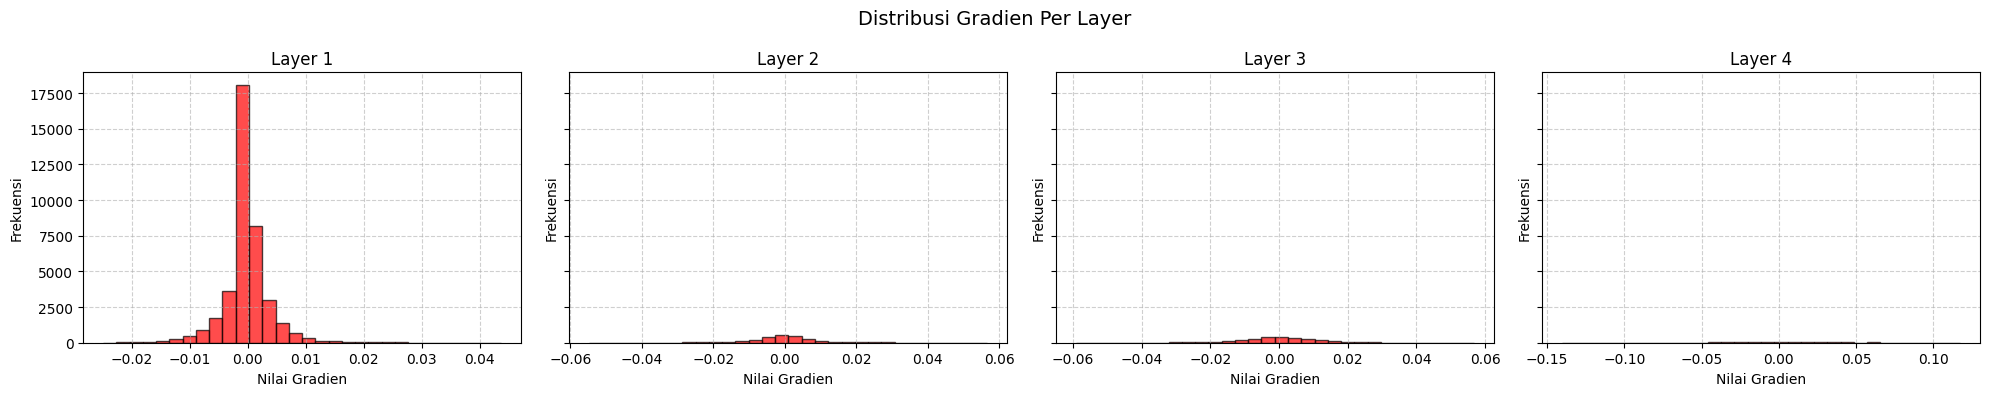


 Depth 6 Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.4371 - Validation Loss: 0.3168 - 3.70s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.263464  | 0.437975
    2 |  0.434711  | 0.456548
    3 |  0.464425  | 0.373264
    4 |  0.373173  | 0.360284
    5 |  0.362168  | 0.418347
    6 |  0.414989  | 0.705871
    7 |  0.702114  | 0.560923
    8 |  0.558367  | 0.711042
    9 |  0.703216  | 0.439578
   10 |  0.434010  | 0.568324
   11 |  0.565352  | 0.515848
   12 |  0.519210  | 0.546616
   13 |  0.542429  | 0.543632
   14 |  0.538471  | 0.412280
   15 |  0.411894  | 0.369615
   16 |  0.374623  | 0.399044
   17 |  0.390732  | 0.394344
   18 |  0.391944  | 0.333425
   19 |  0.331185  | 0.440075
   20 |  0.437058  | 0.316777


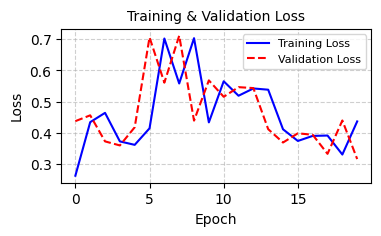

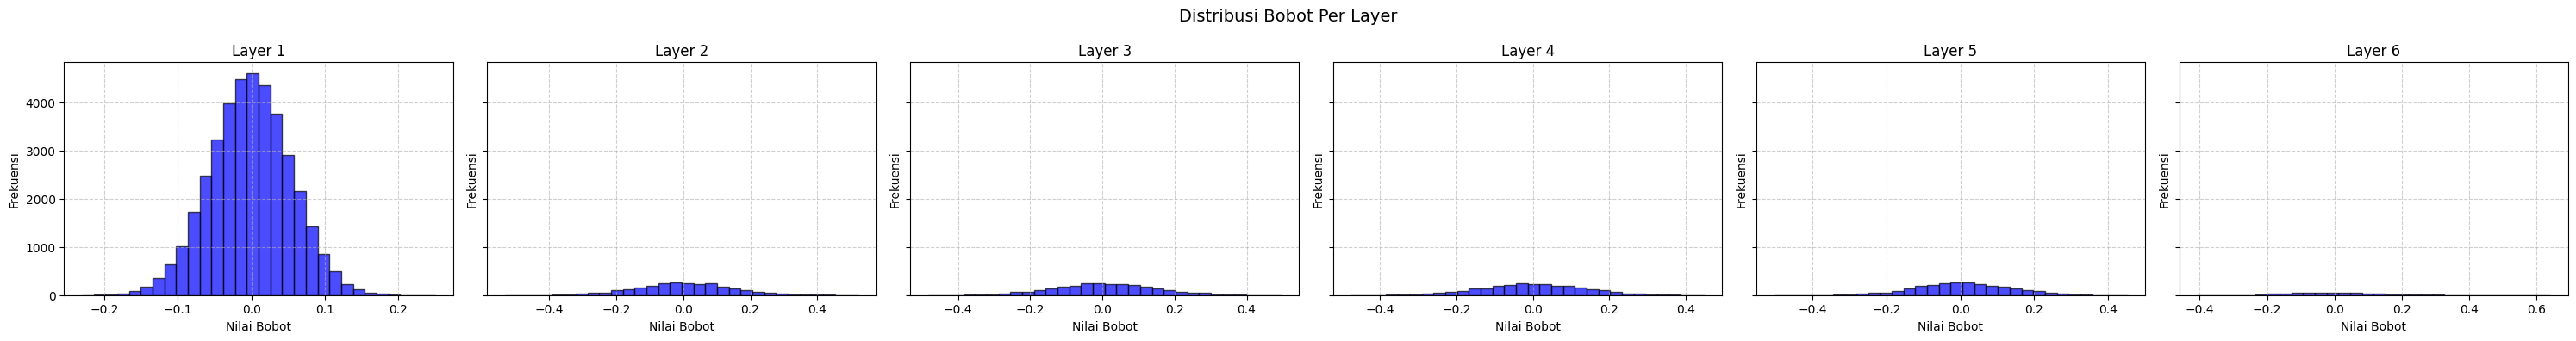

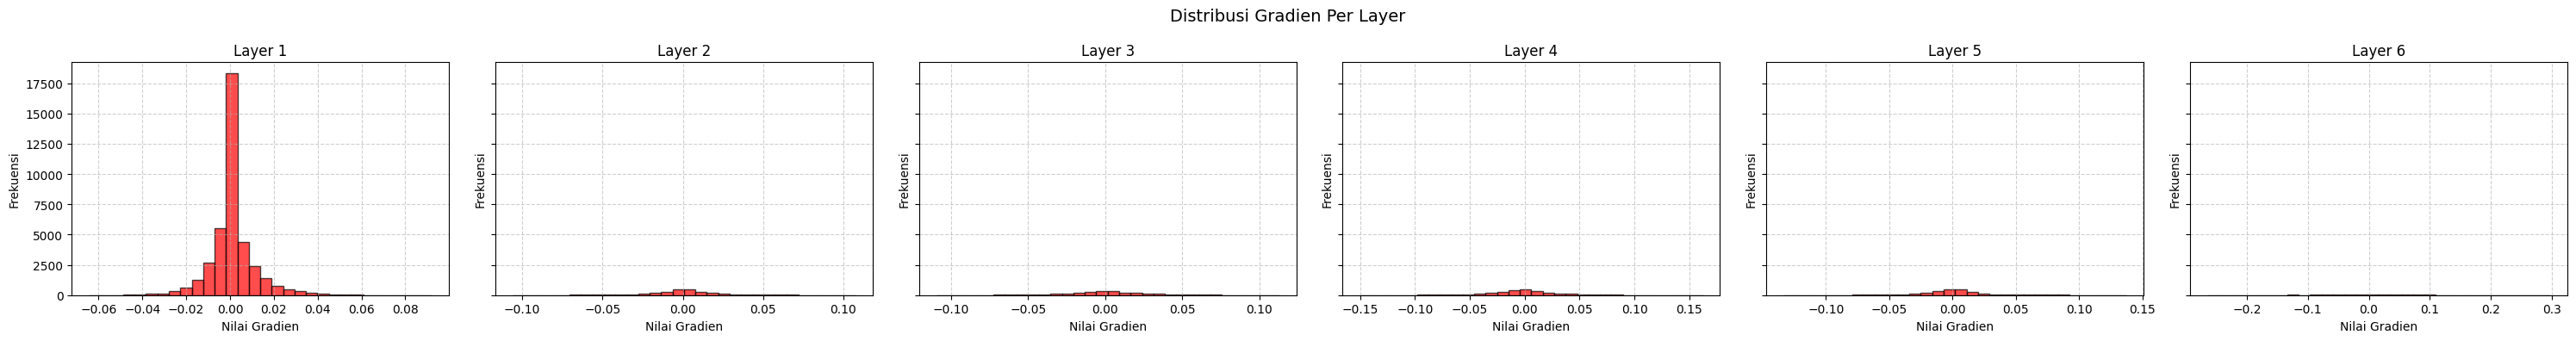

In [9]:
depth_var = [2, 4, 6]

for depth in depth_var:
    print(f"\n Depth {depth} Result\n")
    ffnn, acc = train_ffnn(depth=depth, width=50, learning_rate=0.001, activation=tanh, weight_init='xavier')
    results[f"Depth {depth}"] = acc

Dari hasil pengujian, terlihat bahwa semakin dalam depth nya nilai training loss dan validation loss nya semakin meningkat. Namun, depth 4 memberikan nilai loss yang paling optimum yaitu 0.08 dengan nilai akurasi yang diberikan adalah 59.29%. Semua depth memberikan nilai validation loss yang  lebih rendah dari training loss yang mengartikan bahwa model dengan depth tersebut tidak overfitting.

Selanjutnya peninjauan kedua dilakukan terhadap distribusi bobot per layernya. Pada depth 2, distribusi bobot pada layer pertama tampak merata, menunjukkan bahwa pembelajaran terjadi dengan cukup baik, tetapi layer kedua memiliki bobot yang hampir tidak bervariasi cenderung berada pada sekitar nilai nol. Pada depth 4, bobot mulai terdistribusi dengan pola lebih tajam di sekitar nol, dan beberapa layer memiliki bobot dengan dengan nilai berskala besar. Pada depth 6, distribusi bobot semakin ekstrim dan nilai distribusi bobot yang meningkat, yang berpotensi menyebabkan eksploding gradients. Secara keseluruhan, model dengan depth yang lebih besar cenderung mengalami ketidakstabilan dalam pembelajaran jika tidak dikontrol dengan baik menggunakan normalisasi atau regularisasi.

Terakhir peninjauan dilakukan terhadap distribusi gradien per layernya. Distribusi gradien menunjukkan bahwa semakin dalam arsitektur jaringan, semakin besar masalah vanishing gradient yang terjadi. Pada depth 2, gradien terkonsentrasi di layer pertama, sementara layer kedua hampir tidak belajar. Pada depth 4 dan 6, hanya layer awal yang menerima gradien signifikan, sedangkan layer-layer selanjutnya mengalami penurunan tajam nilai gradien, menandakan pembelajaran yang tidak efektif di lapisan terdalam. Selain itu, skala yang semakin besar, menandakan kemungkinan eksploding gradients. Secara keseluruhan, semakin dalam model maka akan semakin rentan terhadap masalah vanishing atau eksploding gradients. Masalah vanishing dapat menyebabkan model sulit untuk mengupdate bobot secara efektif karena tidak ada perubahan selama pembelajaran yang berdampak pada performansi yang semakin menurun. Selain itu, untuk masalah eksploding gradient menyebabkan pembaruan bobot sulit dikendalikan. Oleh karena itu, model ini masih memerlukan teknik lebih lanjut seperti normalisasi, regulasi, atau optimisasi yang lebih baik untuk menjaga stabilitas pembelajaran.


Selanjutnya peninjauan kedua dilakukan terhadap distribusi bobot per layernya. Pada depth 2, distribusi bobot pada layer pertama tampak merata, menunjukkan bahwa pembelajaran terjadi dengan cukup baik, tetapi layer kedua memiliki bobot yang hampir tidak bervariasi cenderung berada pada sekitar nilai nol. Pada depth 4, bobot mulai terdistribusi dengan pola lebih tajam di sekitar nol, dan beberapa layer memiliki bobot dengan dengan nilai berskala besar. Pada depth 6, distribusi bobot semakin ekstrim dan nilai distribusi bobot yang meningkat, yang berpotensi menyebabkan eksploding gradients. Secara keseluruhan, model dengan depth yang lebih besar cenderung mengalami ketidakstabilan dalam pembelajaran jika tidak dikontrol dengan baik menggunakan normalisasi atau regularisasi.

Terakhir peninjauan dilakukan terhadap distribusi gradien per layernya. Pada depth 2, distribusi gradien menunjukkan bahwa mayoritas nilai gradien terkonsentrasi di sekitar nol, terutama pada layer pertama, sementara layer kedua hampir tidak mengalami perubahan. Pada depth 4, nilai gradien semakin meningkat dengan nilai yang lebih besar, terutama pada layer pertama, yang menunjukkan potensi ketidakstabilan dalam pembelajaran. Pada depth 6, masalah ini semakin memburuk dengan distribusi gradien yang sangat tajam atau berarti sebagian besar nilai gradiennya sangat kecil dan terkonsentrasi di sekitar nol yang mengindikasikan masalah vanishing gradients. Selain itu, skala yang semakin besar, menandakan kemungkinan eksploding gradients. Secara keseluruhan, semakin dalam model maka akan semakin rentan terhadap masalah vanishing atau eksploding gradients. Masalah vanishing dapat menyebabkan model sulit untuk mengupdate bobot secara efektif karena tidak ada perubahan selama pembelajaran yang berdampak pada performansi yang semakin menurun. Selain itu, untuk masalah eksploding gradient menyebabkan pembaruan bobot sulit dikendalikan. Oleh karena itu, model ini masih memerlukan teknik lebih lanjut seperti normalisasi, regulasi, atau optimisasi yang lebih baik untuk menjaga stabilitas pembelajaran.

### Pengaruh Learning Rates


 Learning Rate 0.001 Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.3169 - Validation Loss: 0.2470 - 1.70s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.395064  | 0.513210
    2 |  0.510023  | 0.396687
    3 |  0.390697  | 0.386024
    4 |  0.384803  | 0.334973
    5 |  0.332446  | 0.336084
    6 |  0.336466  | 0.318001
    7 |  0.314168  | 0.275864
    8 |  0.270681  | 0.301120
    9 |  0.298509  | 0.555022
   10 |  0.548461  | 0.295261
   11 |  0.288478  | 0.287709
   12 |  0.282444  | 0.296277
   13 |  0.291178  | 0.331482
   14 |  0.328489  | 0.396708
   15 |  0.394541  | 0.261479
   16 |  0.253242  | 0.612048
   17 |  0.607678  | 0.513855
   18 |  0.514024  | 0.339889
   19 |  0.332760  | 0.320374
   20 |  0.316889  | 0.246955


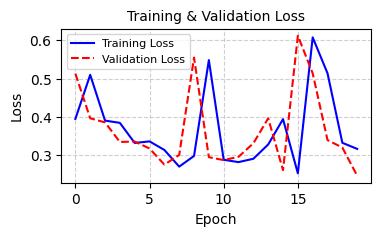

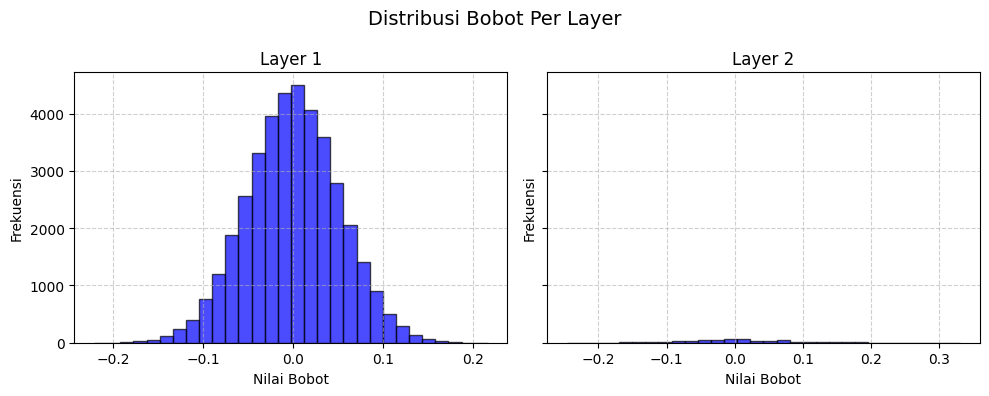

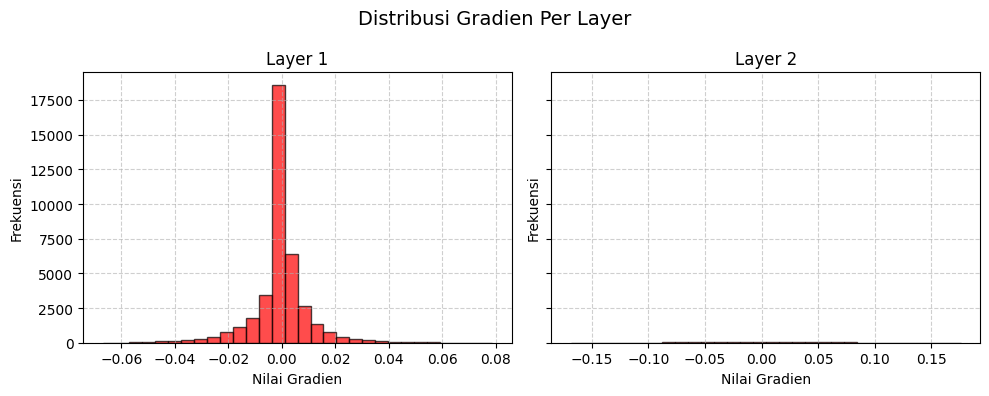


 Learning Rate 0.01 Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.6862 - Validation Loss: 0.6786 - 1.69s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.395064  | 0.692550
    2 |  0.690989  | 0.892515
    3 |  0.891871  | 0.861959
    4 |  0.860824  | 0.790322
    5 |  0.789595  | 0.828638
    6 |  0.828194  | 0.773453
    7 |  0.773970  | 0.802584
    8 |  0.802881  | 0.764213
    9 |  0.762368  | 0.737575
   10 |  0.737058  | 0.818962
   11 |  0.819354  | 0.783764
   12 |  0.782454  | 0.755220
   13 |  0.754903  | 0.734554
   14 |  0.730362  | 0.769866
   15 |  0.765922  | 0.788304
   16 |  0.786652  | 0.750618
   17 |  0.750879  | 0.702674
   18 |  0.698841  | 0.681954
   19 |  0.678791  | 0.690998
   20 |  0.686167  | 0.678645


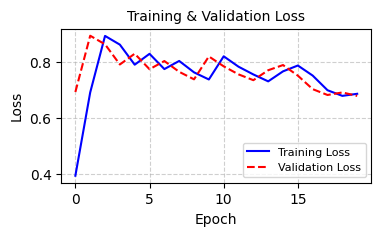

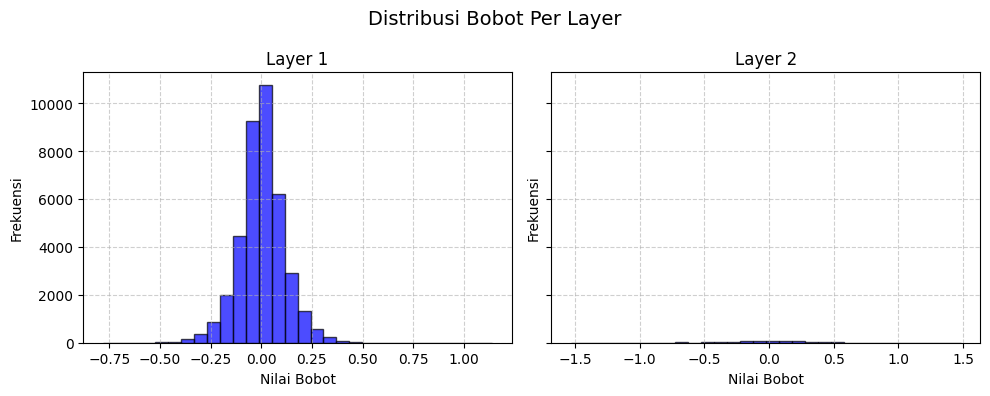

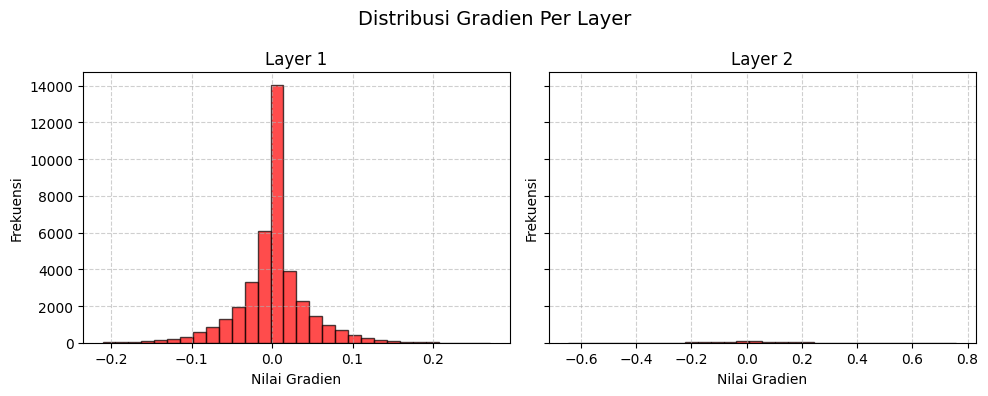


 Learning Rate 0.1 Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.8848 - Validation Loss: 0.8866 - 1.60s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.395064  | 1.202531
    2 |  1.204248  | 1.153647
    3 |  1.155787  | 1.119233
    4 |  1.120407  | 1.091614
    5 |  1.093477  | 1.042414
    6 |  1.041905  | 0.994528
    7 |  0.990881  | 0.967611
    8 |  0.960876  | 0.931502
    9 |  0.928420  | 0.913359
   10 |  0.910502  | 0.898608
   11 |  0.896813  | 0.899105
   12 |  0.896107  | 0.910923
   13 |  0.908409  | 0.904843
   14 |  0.902985  | 0.896039
   15 |  0.893883  | 0.894897
   16 |  0.893218  | 0.895254
   17 |  0.891679  | 0.891339
   18 |  0.888547  | 0.889909
   19 |  0.888531  | 0.887858
   20 |  0.884845  | 0.886602


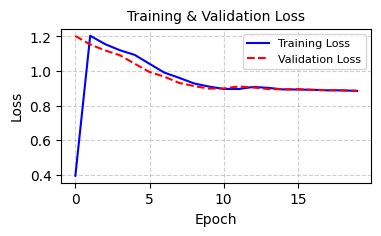

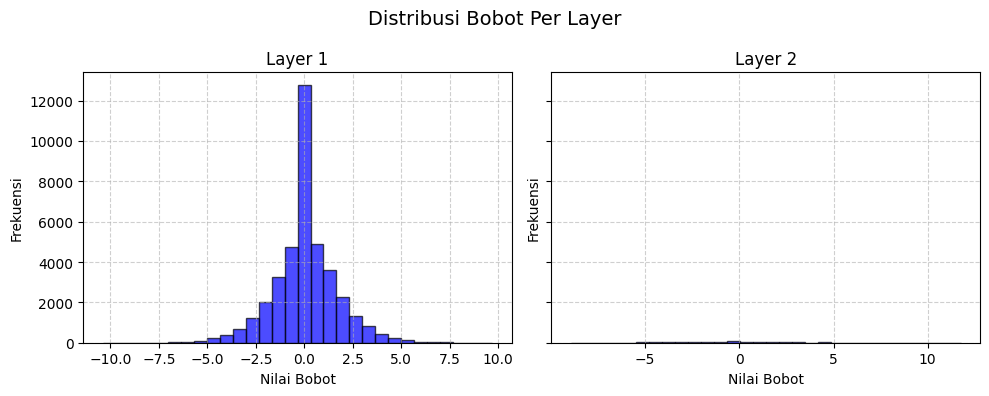

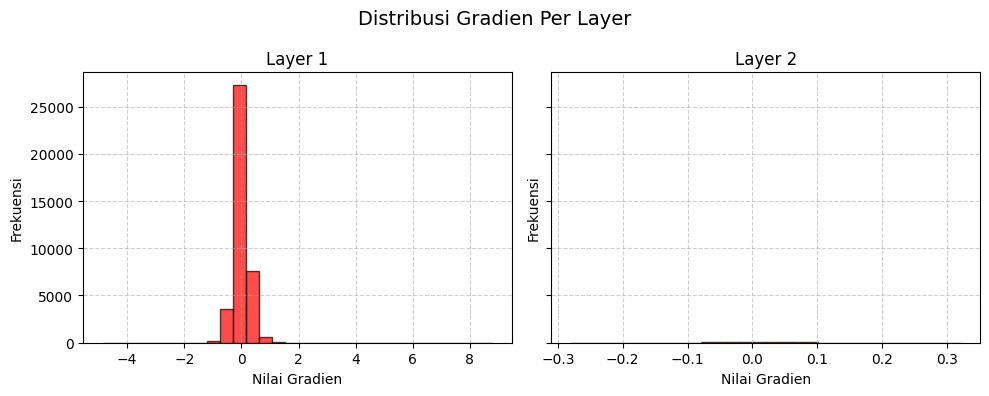

In [10]:
learning_rates = [0.001, 0.01, 0.1]

for lr in learning_rates:
    print(f"\n Learning Rate {lr} Result\n")
    ffnn, acc = train_ffnn(depth=2, width=50, learning_rate=lr, activation=tanh, weight_init='xavier')
    results[f"LR {lr}"] = acc

Dari hasil uji coba, pengaruh learning rate berturut-turut dari percobaan learning rate 0,001; 0,01; 0,1 berturut-turut memberikan nilai 0,246; 0,979; dan 0,887.  Hal ini menunjukkan bahwa semakin kecil learning rate maka nilai validation lossnya akan semakin mengecil. Terakhir, Pengujian dengan learning rate 0.001 memberikan nilai yang optimal.

Pada learning rate 0.001, distribusi bobot masih relatif normal dan terpusat di sekitar nol tapi tersebar secara merata, menunjukkan pembelajaran berlangsung dengan stabil. Ketika learning rate meningkat menjadi 0.01, nilai bobot mulai membesar dengan beberapa nilai ekstrim, menandakan adanya peningkatan variabilitas dalam pembaruan bobot. Pada learning rate 0.1, distribusi bobot semakin menyebar luas dengan nilai yang jauh lebih besar, yang mengindikasikan kemungkinan exploding gradient atau pembaruan bobot menjadi terlalu besar akibat akumulasi gradien yang terus meningkat, menyebabkan nilai bobot membesar secara tidak terkendali. Hal ini dapat menghambat konvergensi model dan bahkan membuat training menjadi tidak stabil. Oleh karena itu, bisa disimpulkan bahwa semakin tinggi nilai learning rate menyebabkan bobot model membesar secara tidak stabil, yang dapat mengarah ke divergensi selama training.

Distribusi gradien per layer menunjukkan bahwa semakin besar nilai learning rate, semakin tinggi risiko terjadinya exploding gradient. Pada learning rate 0.001, distribusi gradien masih terkendali dan mayoritas nilai berada di sekitar nol, terutama pada layer pertama, sementara layer kedua hampir tidak aktif. Saat learning rate dinaikkan ke 0.01, rentang gradien mulai melebar, mengindikasikan awal ketidakstabilan pembaruan bobot meskipun pusat distribusi tetap di nol. Pada learning rate 0.1, gradien mengalami lonjakan drastis dengan nilai yang sangat besar pada layer pertama, menandakan exploding gradient yang serius, sedangkan layer kedua tetap pasif. Pola ini memperlihatkan bahwa peningkatan learning rate secara signifikan dapat mengganggu stabilitas pelatihan model.

### Pengaruh Inisialisasi Bobot


 zero weight initializations Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.0900 - Validation Loss: 0.0900 - 1.70s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.100000  | 0.089979
    2 |  0.089980  | 0.089979
    3 |  0.089980  | 0.089979
    4 |  0.089980  | 0.089979
    5 |  0.089980  | 0.089979
    6 |  0.089980  | 0.089979
    7 |  0.089980  | 0.089979
    8 |  0.089980  | 0.089979
    9 |  0.089980  | 0.089979
   10 |  0.089980  | 0.089979
   11 |  0.089980  | 0.089979
   12 |  0.089980  | 0.089979
   13 |  0.089980  | 0.089979
   14 |  0.089980  | 0.089979
   15 |  0.089980  | 0.089979
   16 |  0.089980  | 0.089979
   17 |  0.089980  | 0.089979
   18 |  0.089980  | 0.089979
   19 |  0.089980  | 0.089979
   20 |  0.089980  | 0.089979


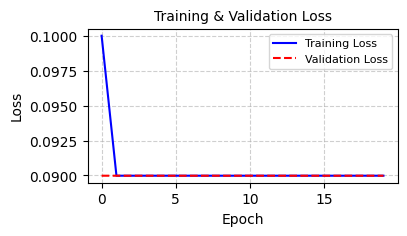

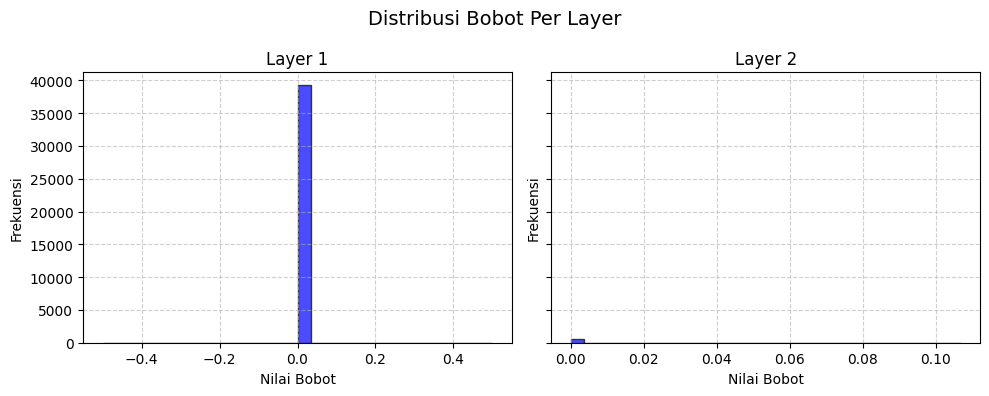

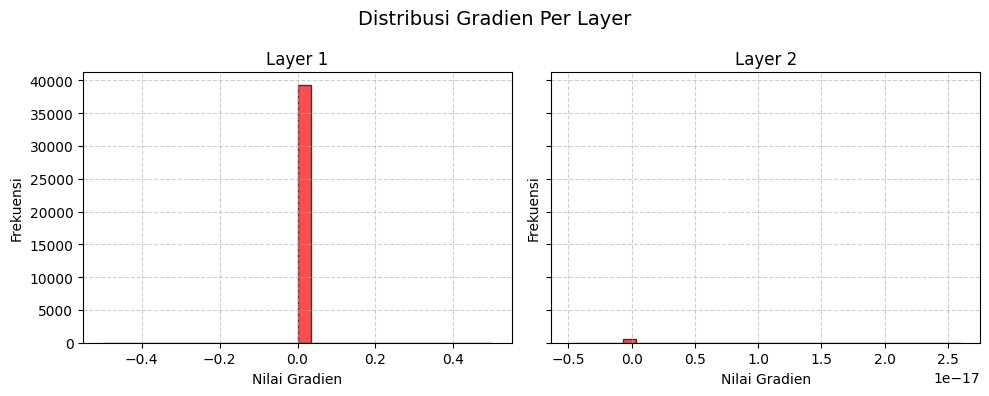


 normal weight initializations Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.8101 - Validation Loss: 0.8350 - 1.70s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.956252  | 0.931899
    2 |  0.931711  | 0.912844
    3 |  0.910565  | 0.897374
    4 |  0.891930  | 0.885984
    5 |  0.877648  | 0.876865
    6 |  0.867699  | 0.870079
    7 |  0.859345  | 0.865309
    8 |  0.852353  | 0.860885
    9 |  0.846342  | 0.857446
   10 |  0.840907  | 0.854300
   11 |  0.836715  | 0.851333
   12 |  0.832624  | 0.848467
   13 |  0.828523  | 0.845739
   14 |  0.824432  | 0.843500
   15 |  0.820994  | 0.841771
   16 |  0.818162  | 0.840310
   17 |  0.815733  | 0.838734
   18 |  0.814127  | 0.837521
   19 |  0.811734  | 0.836141
   20 |  0.810056  | 0.834996


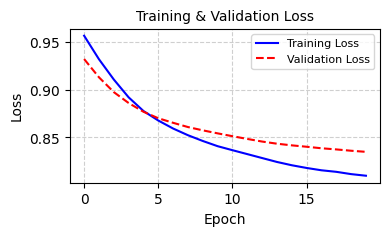

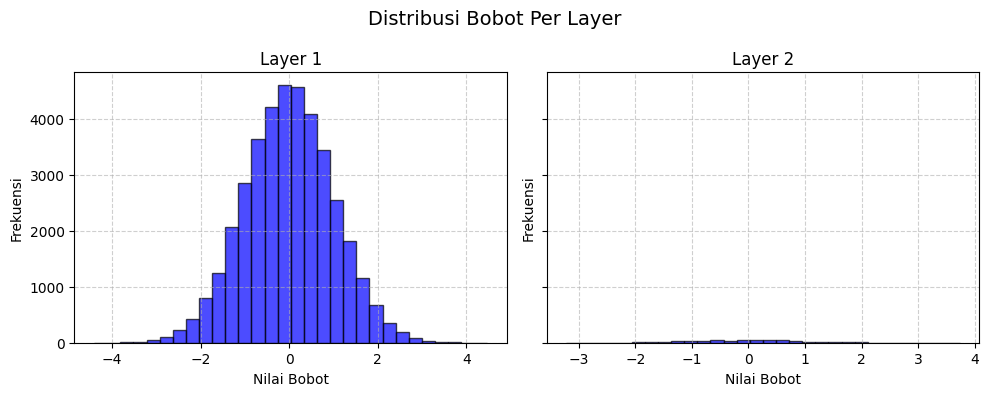

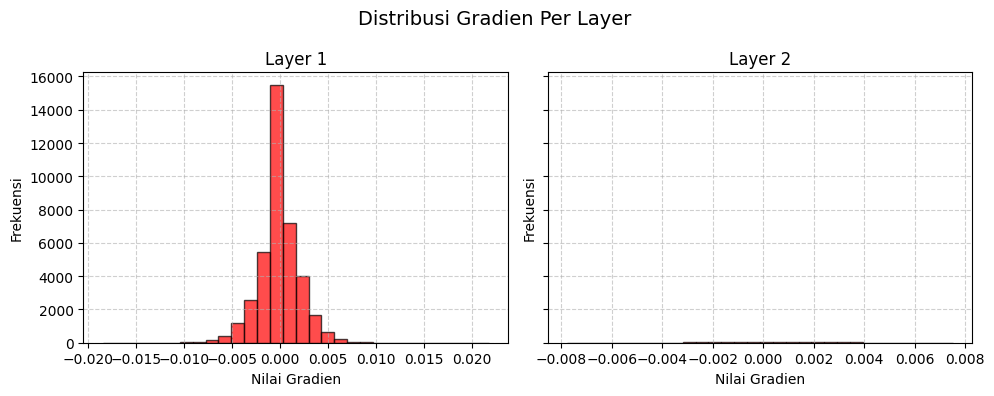


 uniform weight initializations Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.0923 - Validation Loss: 0.0873 - 1.70s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.750921  | 0.640806
    2 |  0.635111  | 0.574884
    3 |  0.567030  | 0.535634
    4 |  0.523974  | 0.503481
    5 |  0.488618  | 0.478186
    6 |  0.461566  | 0.466951
    7 |  0.448635  | 0.446773
    8 |  0.430132  | 0.420592
    9 |  0.401707  | 0.386617
   10 |  0.368704  | 0.345344
   11 |  0.326004  | 0.309495
   12 |  0.291741  | 0.271141
   13 |  0.253313  | 0.240568
   14 |  0.225790  | 0.211225
   15 |  0.197232  | 0.183159
   16 |  0.172527  | 0.150069
   17 |  0.141063  | 0.122311
   18 |  0.116537  | 0.110088
   19 |  0.104767  | 0.096099
   20 |  0.092327  | 0.087267


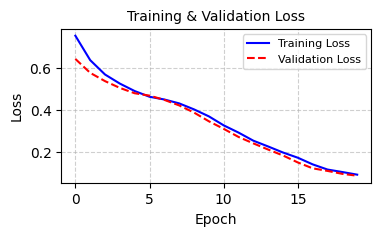

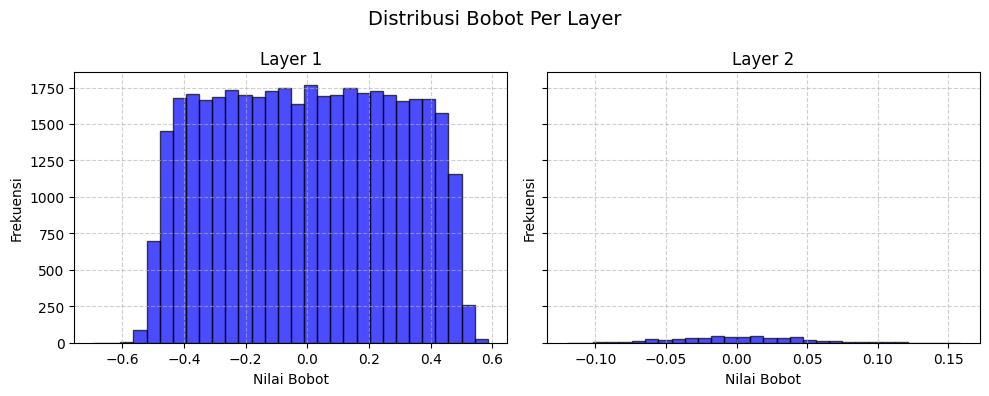

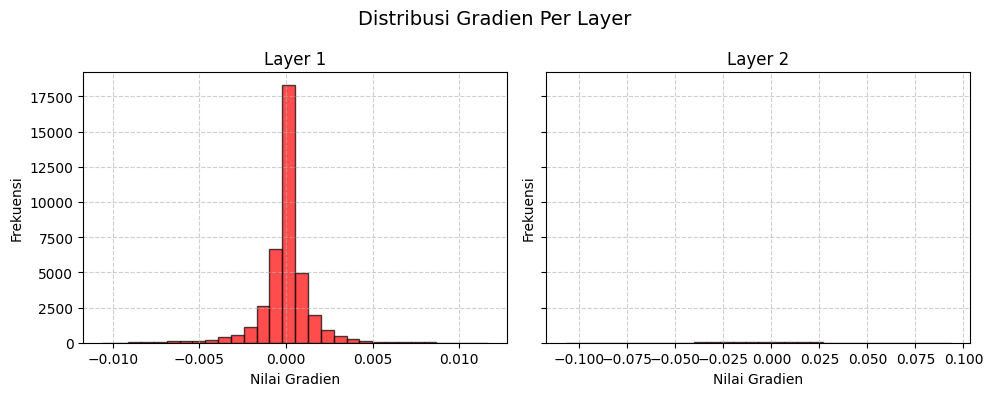


 xavier weight initializations Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.3169 - Validation Loss: 0.2470 - 1.60s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.395064  | 0.513210
    2 |  0.510023  | 0.396687
    3 |  0.390697  | 0.386024
    4 |  0.384803  | 0.334973
    5 |  0.332446  | 0.336084
    6 |  0.336466  | 0.318001
    7 |  0.314168  | 0.275864
    8 |  0.270681  | 0.301120
    9 |  0.298509  | 0.555022
   10 |  0.548461  | 0.295261
   11 |  0.288478  | 0.287709
   12 |  0.282444  | 0.296277
   13 |  0.291178  | 0.331482
   14 |  0.328489  | 0.396708
   15 |  0.394541  | 0.261479
   16 |  0.253242  | 0.612048
   17 |  0.607678  | 0.513855
   18 |  0.514024  | 0.339889
   19 |  0.332760  | 0.320374
   20 |  0.316889  | 0.246955


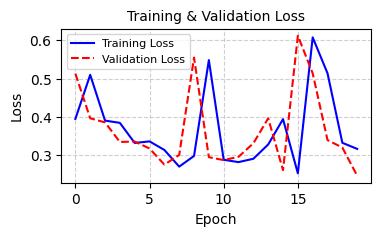

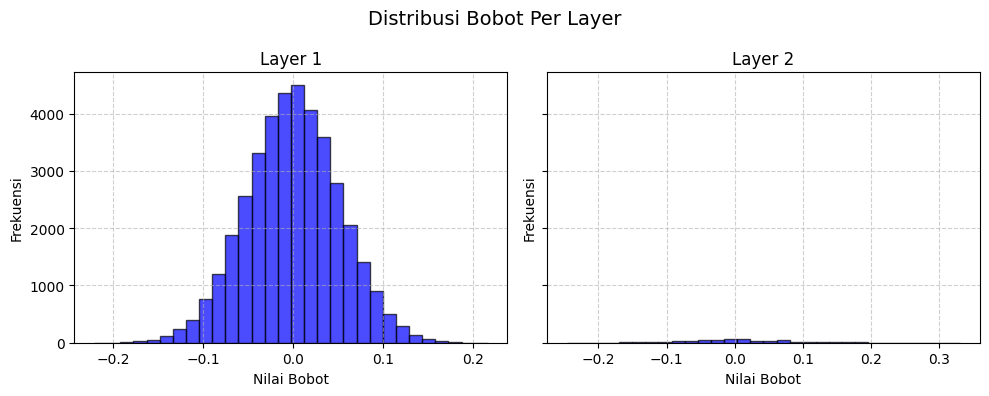

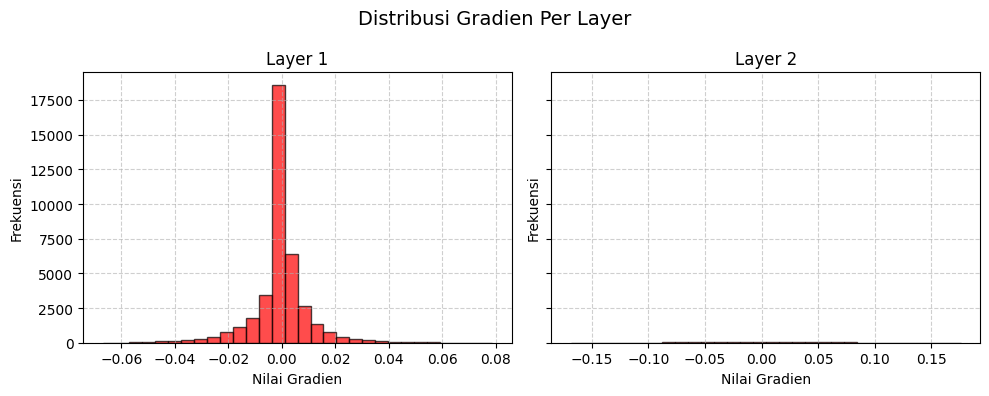


 he weight initializations Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.6852 - Validation Loss: 0.5243 - 1.70s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.430087  | 0.546343
    2 |  0.543166  | 0.428087
    3 |  0.421928  | 0.436081
    4 |  0.435326  | 0.417561
    5 |  0.415683  | 0.397107
    6 |  0.399061  | 0.368510
    7 |  0.365893  | 0.300374
    8 |  0.300414  | 0.310841
    9 |  0.308976  | 0.195518
   10 |  0.194674  | 0.306215
   11 |  0.300852  | 0.145818
   12 |  0.141828  | 0.172217
   13 |  0.169734  | 0.165469
   14 |  0.161457  | 0.206227
   15 |  0.203209  | 0.169657
   16 |  0.167656  | 0.183806
   17 |  0.184878  | 0.413893
   18 |  0.418095  | 0.308720
   19 |  0.308077  | 0.686225
   20 |  0.685205  | 0.524347


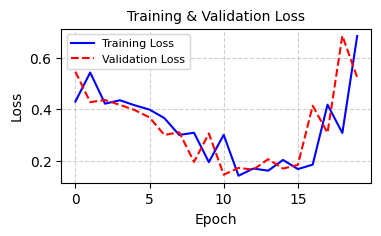

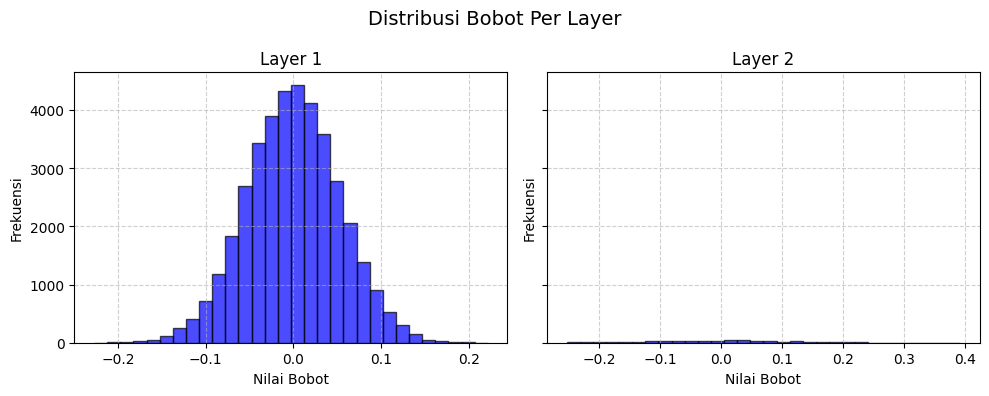

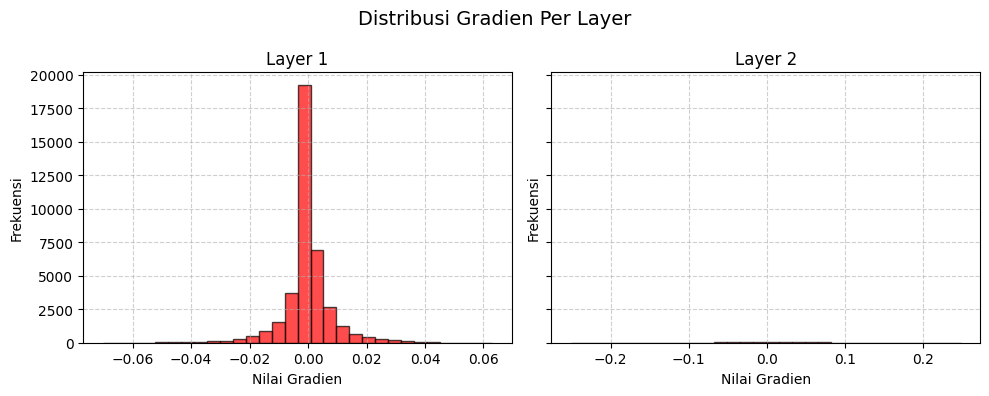

In [11]:
weight_initializations = ['zero','normal', 'uniform','xavier', 'he']

for init in weight_initializations:
    print(f"\n {init} weight initializations Result\n")
    ffnn, acc = train_ffnn(depth=2, width=50, learning_rate=0.001, activation=tanh, weight_init=init)
    results[f"Weight Init {init}"] = acc

Dari hasil uji coba, penggunaan inisialisasi Uniform weight memberikan model  yang cukup optimal. Hal ini bisa dilihat dari grafik validation error yang menurun dengan nilai loss validation akhir 0.087 namun hal ini memiliki potensi overfit pada train data. Selanjutnya Xavier memiliki nilai validation yang cukup rendah di akhir yakni, 0.246 meskipun grafik naik turun pada validation loss dan training loss xavier memberikan nilai yang rendah di akhir epoch dan menunjukkan model tidak overfitting. Pada zero weight proses penurunan loss terjadi sangat lambat sehingga perubahan loss yang terjadi pada tiap epoch tidak signifikan. Sedangkan inisialisasi He menghasilkan model yang overfit karena nilai validation yang meningkat pada akhir epoch. Untuk normal, terlihat grafik yang terus menurun namun penurunan loss yang terjadi juga sangat lambat untuk setiap epochnya.

Dari berbagai metode inisialisasi bobot, Xavier dan He Weight menunjukkan distribusi bobot yang lebih stabil dibandingkan metode lainnya, menjadikannya pilihan terbaik. Zero Weight menyebabkan semua neuron memiliki output yang sama. Normal weight dan Uniform Weight cenderung mengalami distribusi bobot pada layer yang lebih tinggi, yang dapat menyebabkan menurunnya nilai gradien saat backpropagation. Meski begitu, pada hasil akurasi pada test set uniform memiliki nilai akurasi yang paling tinggi dibanding yang lainnya. Dengan demikian, pemilihan metode inisialisasi yang tepat dapat berpengaruh terhadap stabilitas dan konvergensi model selama proses training.

Dari analisis distribusi gradien pada berbagai metode inisialisasi bobot, terlihat bahwa Zero Weight menyebabkan gradien seluruh layer bernilai nol, yang menyebabkan model tidak melakukan pembelajaran karena backpropagation tidak berjalan. He dan Uniform Weight menghasilkan gradien yang terlalu besar di beberapa layer, berpotensi menyebabkan exploding gradient. Xavier dan normal mendistribusikan gradien dengan lebih stabil di seluruh layer, cocok untuk aktivasi sigmoid dan tanh.

### Pengaruh Fungsi Aktivasi


 tanh activation Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.3169 - Validation Loss: 0.2470 - 1.79s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.395064  | 0.513210
    2 |  0.510023  | 0.396687
    3 |  0.390697  | 0.386024
    4 |  0.384803  | 0.334973
    5 |  0.332446  | 0.336084
    6 |  0.336466  | 0.318001
    7 |  0.314168  | 0.275864
    8 |  0.270681  | 0.301120
    9 |  0.298509  | 0.555022
   10 |  0.548461  | 0.295261
   11 |  0.288478  | 0.287709
   12 |  0.282444  | 0.296277
   13 |  0.291178  | 0.331482
   14 |  0.328489  | 0.396708
   15 |  0.394541  | 0.261479
   16 |  0.253242  | 0.612048
   17 |  0.607678  | 0.513855
   18 |  0.514024  | 0.339889
   19 |  0.332760  | 0.320374
   20 |  0.316889  | 0.246955


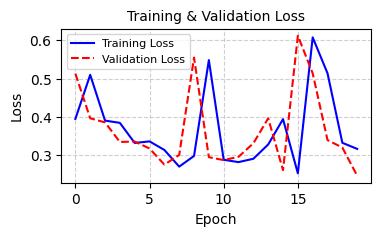

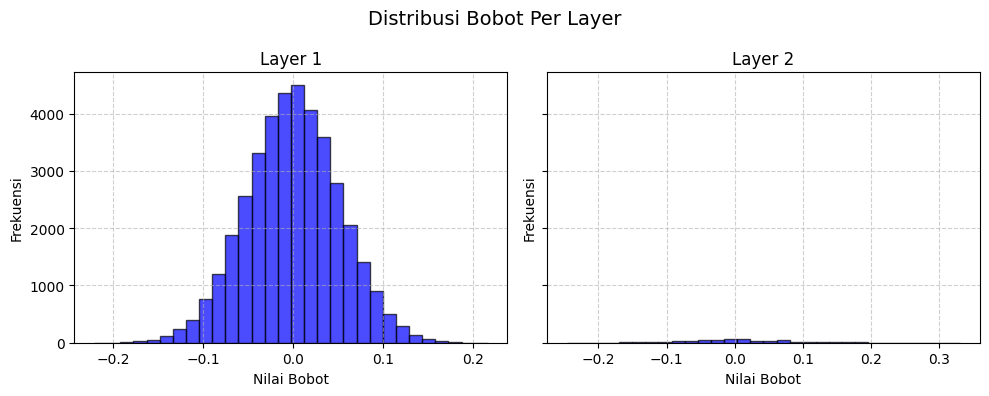

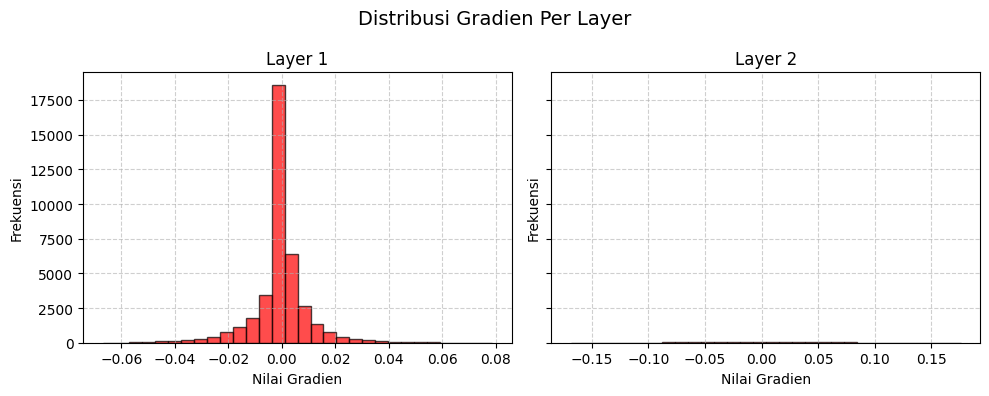


 sigmoid activation Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.5432 - Validation Loss: 0.4181 - 1.60s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.291421  | 1.029281
    2 |  1.023088  | 0.958172
    3 |  0.951565  | 0.947750
    4 |  0.945704  | 0.859608
    5 |  0.860628  | 0.793784
    6 |  0.791922  | 0.697048
    7 |  0.695060  | 0.814231
    8 |  0.810883  | 0.742141
    9 |  0.742029  | 0.832297
   10 |  0.829511  | 0.697361
   11 |  0.695637  | 0.657493
   12 |  0.655019  | 0.716314
   13 |  0.715832  | 0.683855
   14 |  0.682732  | 0.719207
   15 |  0.720462  | 0.634667
   16 |  0.635264  | 0.628234
   17 |  0.626159  | 0.546692
   18 |  0.543960  | 0.615588
   19 |  0.615417  | 0.543279
   20 |  0.543249  | 0.418126


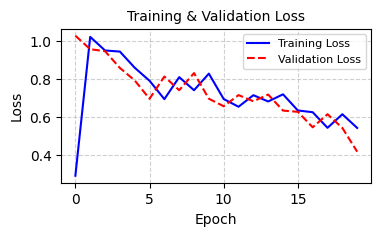

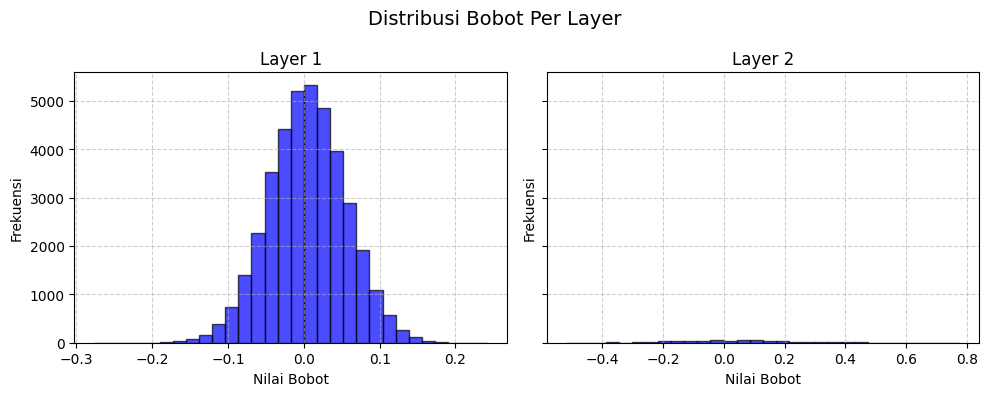

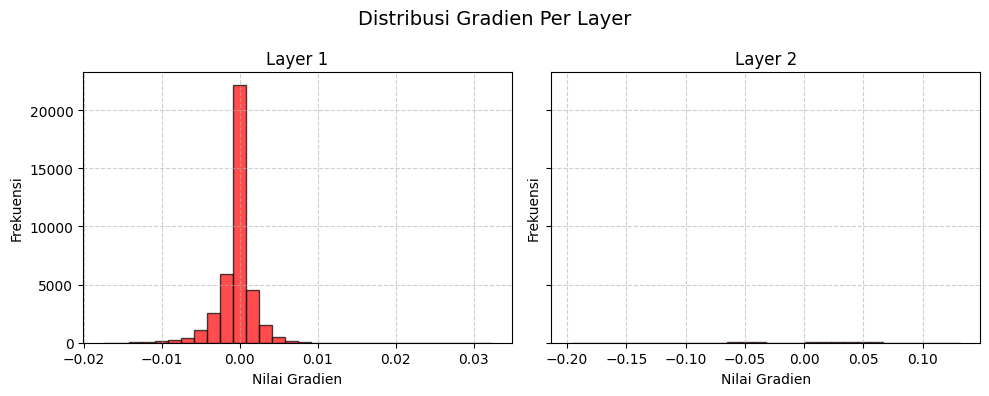


 relu activation Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.1085 - Validation Loss: 0.1146 - 1.50s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.418706  | 0.553434
    2 |  0.550169  | 0.545016
    3 |  0.542005  | 0.410753
    4 |  0.403984  | 0.419646
    5 |  0.411318  | 0.396224
    6 |  0.383545  | 0.294141
    7 |  0.282781  | 0.262323
    8 |  0.253784  | 0.243227
    9 |  0.232677  | 0.285663
   10 |  0.273796  | 0.229359
   11 |  0.218131  | 0.201876
   12 |  0.191046  | 0.185091
   13 |  0.171893  | 0.175395
   14 |  0.164507  | 0.225823
   15 |  0.213101  | 0.168015
   16 |  0.157590  | 0.189069
   17 |  0.177186  | 0.163920
   18 |  0.153009  | 0.144631
   19 |  0.134037  | 0.117531
   20 |  0.108475  | 0.114596


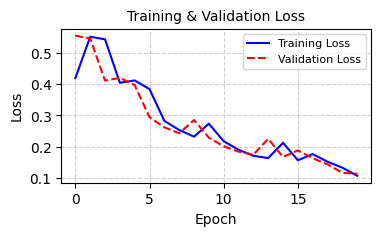

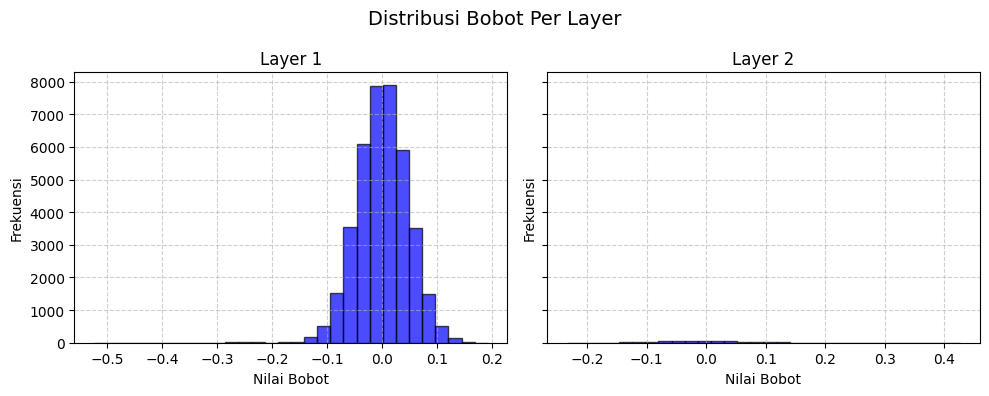

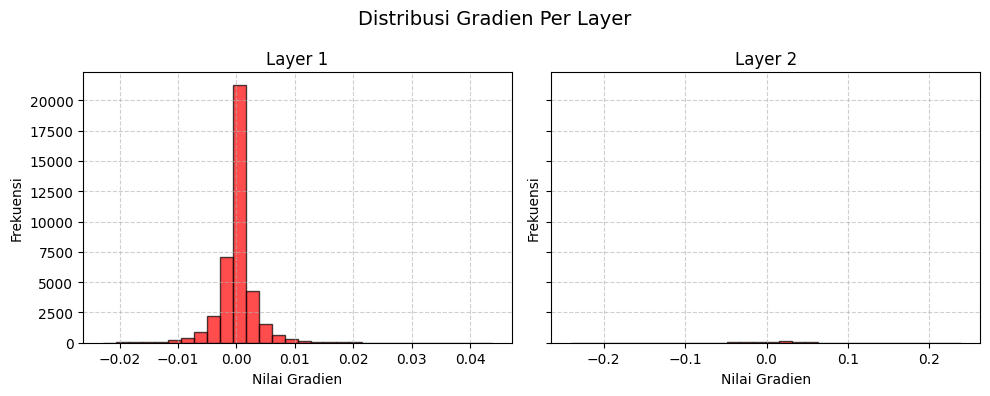


 linear activation Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.5787 - Validation Loss: 0.4690 - 1.60s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.565578  | 0.745598
    2 |  0.740488  | 0.645507
    3 |  0.637543  | 0.578158
    4 |  0.572128  | 0.578397
    5 |  0.581861  | 0.636055
    6 |  0.637870  | 0.492091
    7 |  0.489763  | 0.530494
    8 |  0.521732  | 0.652564
    9 |  0.647944  | 0.584520
   10 |  0.582792  | 0.763828
   11 |  0.770401  | 0.688293
   12 |  0.687867  | 0.596365
   13 |  0.595357  | 0.599912
   14 |  0.593526  | 0.586801
   15 |  0.581957  | 0.574096
   16 |  0.571488  | 0.657749
   17 |  0.650749  | 0.421916
   18 |  0.418336  | 0.620550
   19 |  0.618174  | 0.571132
   20 |  0.578744  | 0.469006


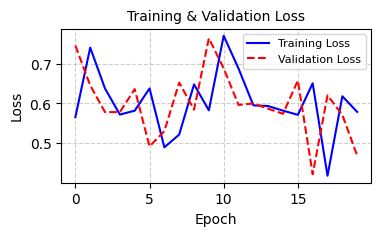

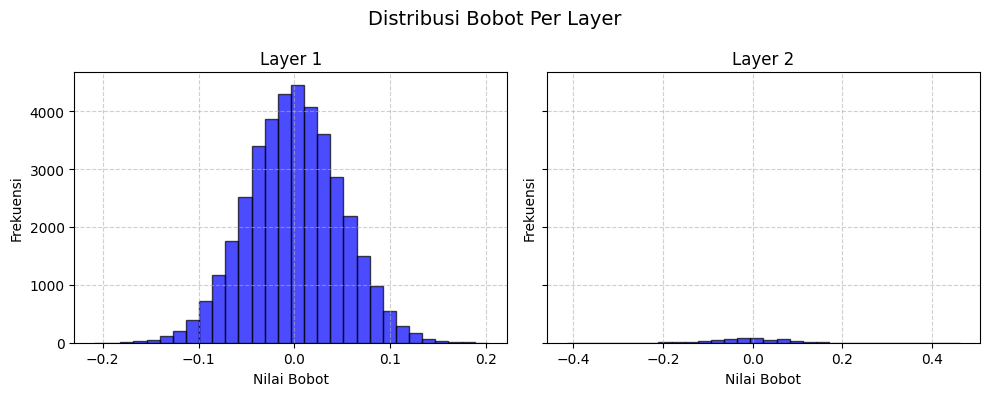

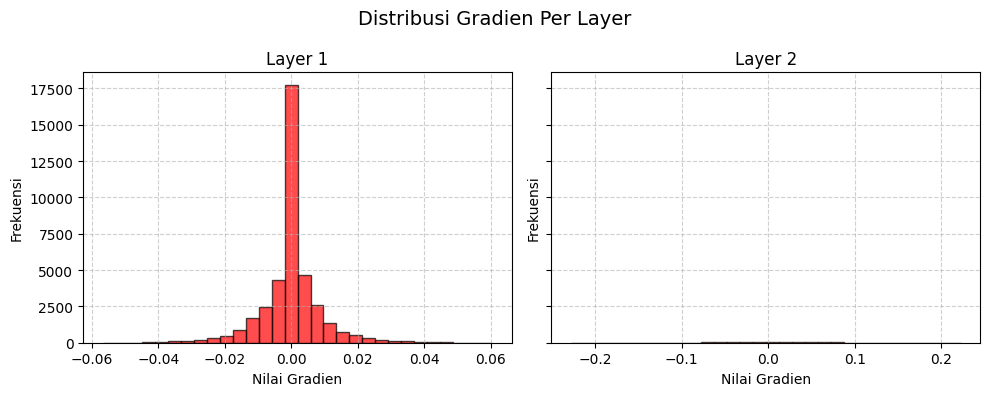


 elu activation Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.4686 - Validation Loss: 0.3756 - 1.80s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.483019  | 0.644125
    2 |  0.641855  | 0.557178
    3 |  0.550319  | 0.472023
    4 |  0.467451  | 0.516658
    5 |  0.513886  | 0.530688
    6 |  0.528863  | 0.371128
    7 |  0.364979  | 0.379094
    8 |  0.375103  | 0.477592
    9 |  0.472931  | 0.484651
   10 |  0.479124  | 0.496236
   11 |  0.486225  | 0.584835
   12 |  0.582887  | 0.445855
   13 |  0.440358  | 0.363351
   14 |  0.354616  | 0.371065
   15 |  0.369156  | 0.320149
   16 |  0.315522  | 0.424054
   17 |  0.419793  | 0.362649
   18 |  0.355548  | 0.495623
   19 |  0.491837  | 0.472079
   20 |  0.468576  | 0.375592


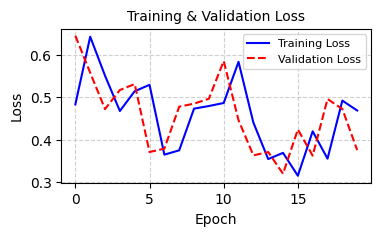

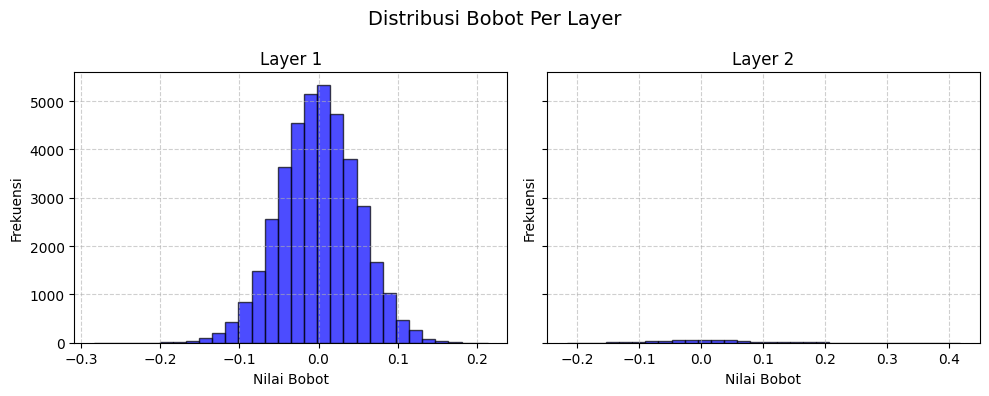

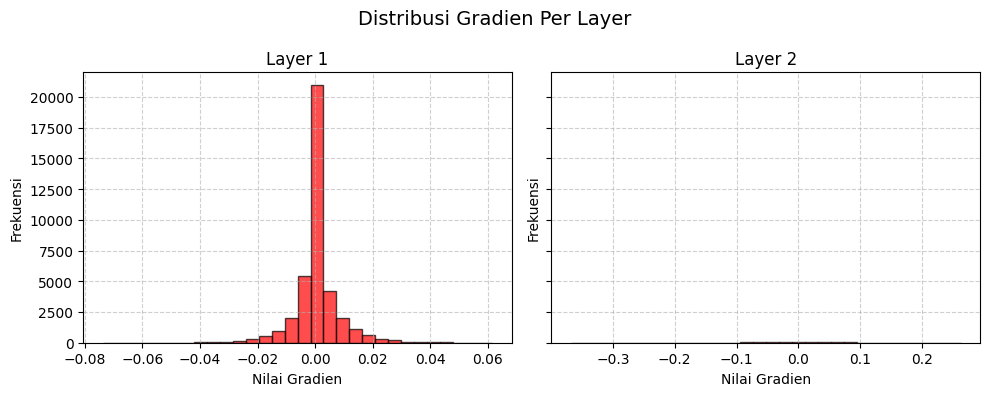


 swish activation Result

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.1095 - Validation Loss: 0.0963 - 1.60s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.380719  | 0.487166
    2 |  0.483428  | 0.423460
    3 |  0.414932  | 0.388756
    4 |  0.382799  | 0.267915
    5 |  0.260181  | 0.322138
    6 |  0.312983  | 0.262267
    7 |  0.256057  | 0.248355
    8 |  0.243596  | 0.229517
    9 |  0.224880  | 0.241434
   10 |  0.233000  | 0.178460
   11 |  0.172276  | 0.200823
   12 |  0.194289  | 0.164213
   13 |  0.157040  | 0.121546
   14 |  0.116716  | 0.183221
   15 |  0.179758  | 0.152263
   16 |  0.146026  | 0.157269
   17 |  0.149294  | 0.132206
   18 |  0.128019  | 0.145555
   19 |  0.139693  | 0.114886
   20 |  0.109485  | 0.096268


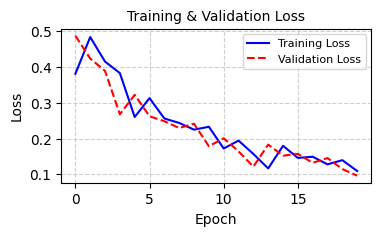

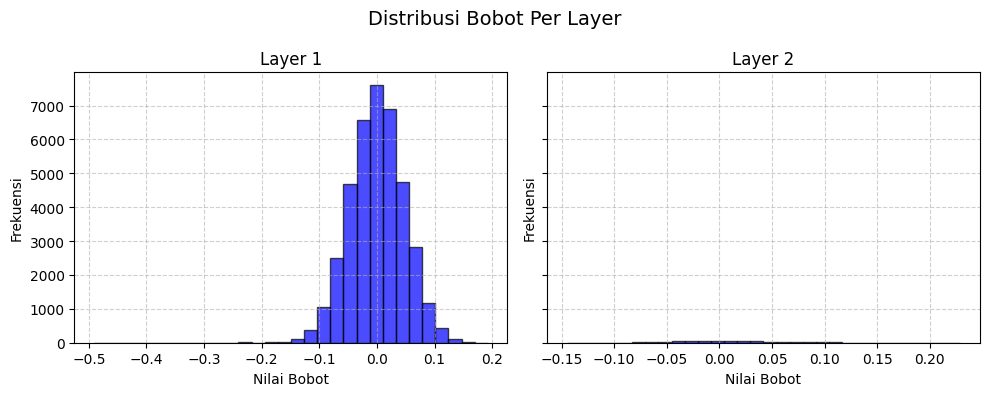

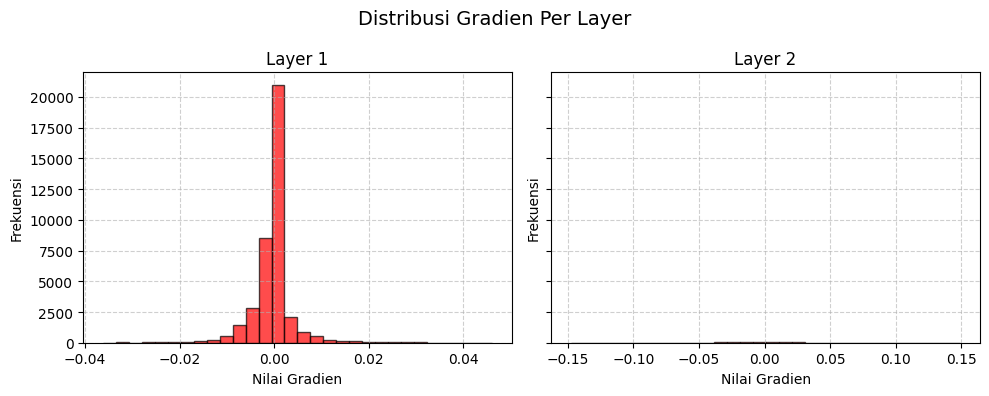

In [12]:
activations = [tanh, sigmoid, relu, linear, elu, swish]

for activation in activations:
    print(f"\n {activation.__name__} activation Result\n")
    ffnn, acc = train_ffnn(depth=2, width=50, learning_rate=0.001, activation=activation, weight_init='xavier')
    results[f"Activation {activation.__name__}"] = acc


Fungsi aktivasi tanh memberikan nilai training loss yang meningkat dan menurun akan tetapi nilai loss semakin menurun setiap terjadi penurunan pada epoch yang lebih besar. Selanjutnya, fungsi aktivasi sigmoid memberikan nilai training loss yang meningkat tajam pada awal epoch dan terus menurun pada epoch selanjutnya. Hal ini mengindikasikan model ini mengalami kesulitan dalam konvergensi kemungkinan karena terjadi vanishing gradient pada lapisan yang lebih dalam. Selanjutnya fungsi aktivasi ReLU memberikan nilai training loss turun yang mengindikasikan model tidak overfit. Pada fungsi aktivasi Linear memberikan nilai training loss yang naik turun secara tidak beraturan. Hal ini juga terjadi pada fungsi aktivasi elu yang memberikan hasil loss yang turun naik secara tidak beraturan. Terakhir, pada fungsi aktivasi swish pada grafik loss terlihat penurunan nilai loss pada epoch yang lebih tinggi walaupun terjadi kenaikan loss pada beberapa epoch, kenaikannya tidak tajam. Sehingga bisa disimpulkan ReLU dan Swish memberikan model yang optimal karena memberikan model yang tidak overfit dan memberikan nilai validation loss paling kecil.

Hasil distribusi bobot menunjukkan bahwa fungsi aktivasi tanh mengalami distribusi bobot yang cenderung stabil dari layer pertama dan layer kedua. Sedangkan pada Sigmoid dan linear mengalami vanishing gradient, di mana nilai bobot mendekati nol seiring bertambahnya kedalaman layer dengan range yang semakin besar, menyebabkan sulit untuk melakukan pembaruan bobot dan training model menjadi lambat. Pada, ReLU dan elu grafik cenderung skewed ke kiri pada layer ke satu dan skewed ke kanan pada layer selanjutnya. Sementara itu, swish cenderung mengalami exploding gradient, dengan distribusi bobot yang lebih luas di layer lebih dalam.  Oleh karena itu, tanh menjadi model yang paling optimal daripada fungsi aktivasi lainnya karena perubahan bobotnya lebih stabil.

Hasil distribusi gradient menunjukkan fungsi aktivasi Tanh dan Sigmoid mengalami pelemahan dengan gradien yang mendekati nol seiring bertambahnya kedalaman layer, menyebabkan masalah vanishing gradient yang menghambat proses pembaruan bobot dan memperlambat training. Sementara itu, ReLU, swish dan linear cenderung mengalami peningkatan distribusi nilai gradien di layer lebih dalam, yang juga dapat menyebabkan exploding gradient, tetapi tetap lebih terkendali dibandingkan elu, yang menunjukkan distribusi gradien yang yang lebih dalam. Akibatnya, model dengan aktivasi elu berisiko mengalami ketidakstabilan selama training, dengan perubahan yang menurun dan meningkat pada training loss dan validation loss yang terus meningkat.



In [13]:
for key, value in results.items():
    print(f"{key}: {float(value):.2f}%")

Width 50: 41.23%
Width 100: 18.75%
Width 200: 29.97%
Depth 2: 41.23%
Depth 4: 59.29%
Depth 6: 15.97%
LR 0.001: 41.23%
LR 0.01: 42.56%
LR 0.1: 29.65%
Weight Init zero: 9.81%
Weight Init normal: 35.18%
Weight Init uniform: 60.32%
Weight Init xavier: 41.23%
Weight Init he: 26.65%
Activation tanh: 41.23%
Activation sigmoid: 23.04%
Activation relu: 70.88%
Activation linear: 11.39%
Activation elu: 34.86%
Activation swish: 64.59%


### Perbandingan dengan MLP

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.0485 - Validation Loss: 0.0489 - 1.41s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.358051  | 0.432641
    2 |  0.432547  | 0.313025
    3 |  0.312197  | 0.333579
    4 |  0.331318  | 0.237307
    5 |  0.231833  | 0.271147
    6 |  0.263449  | 0.209541
    7 |  0.205193  | 0.220975
    8 |  0.213605  | 0.132430
    9 |  0.131030  | 0.184045
   10 |  0.183884  | 0.142037
   11 |  0.140517  | 0.169235
   12 |  0.167602  | 0.144507
   13 |  0.146449  | 0.114805
   14 |  0.114591  | 0.101174
   15 |  0.098608  | 0.071080
   16 |  0.068529  | 0.055855
   17 |  0.054313  | 0.052423
   18 |  0.050402  | 0.051540
   19 |  0.049726  | 0.050568
   20 |  0.048510  | 0.048941


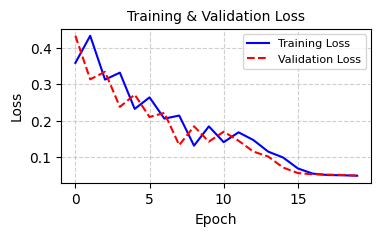

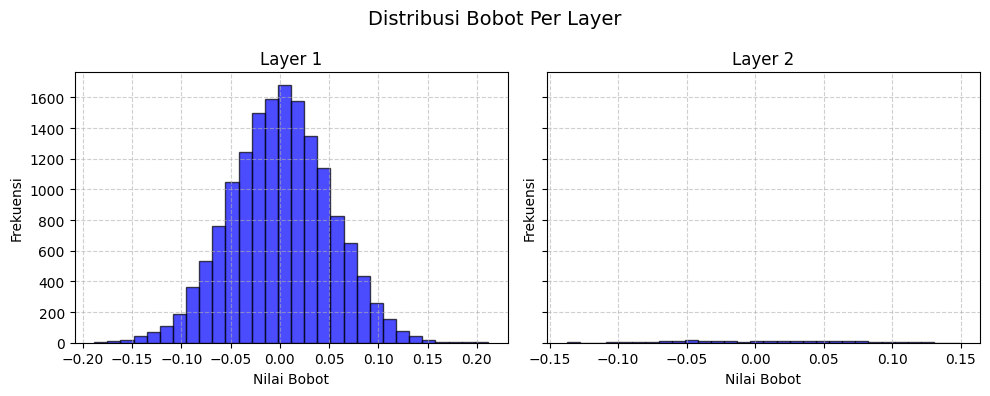

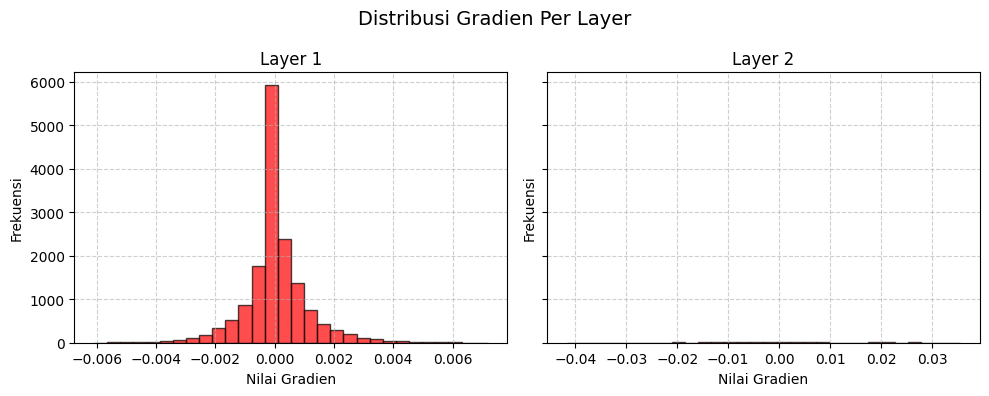

In [33]:
depth = 2
width = 25
learning_rate = 0.001
activation = tanh
weight_init = 'xavier'

ffnn, accuracy_ffnn = train_ffnn(depth=depth, width=width, learning_rate=learning_rate, activation=activation, weight_init=weight_init)

y_pred_ffnn = ffnn.predict(X_test)
y_pred_labels_ffnn = np.argmax(y_pred_ffnn, axis=1)


In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(width,) * (depth - 1),
                    activation='tanh',
                    solver='adam',
                    learning_rate_init=learning_rate,
                    max_iter=20,
                    random_state=42)

mlp.fit(X_train, np.argmax(y_train_oh, axis=1))

y_pred_sklearn = mlp.predict(X_test)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
print(f"Akurasi Model FFNN      : {accuracy_ffnn:.2f}%")
print(f"Akurasi MLP Sklearn     : {accuracy_sklearn:.2f}%")


Akurasi Model FFNN      : 82.40%
Akurasi MLP Sklearn     : 0.90%


Berdasarkan hasil pengujian dengan parameter yang sama, model FFNN menunjukkan akurasi 82.40%, jauh lebih tinggi dibandingkan MLP dari Sklearn yang hanya mencapai 0.90%. Perbedaan ini kemungkinan besar disebabkan oleh MLP Sklearn yang digunakan dengan parameter default tanpa tuning dan tidak memakai regularisasi, sehingga tidak optimal dalam menangani dataset ini. Distribusi bobot dan gradien per layer menunjukkan bahwa model mengalami vanishing gradient pada layer yang lebih dalam, yang dapat menghambat proses learning. Training loss yang menurun dan meningkat juga mengindikasikan adanya overfitting atau learning rate yang tidak stabil, yang perlu diperbaiki dengan penyesuaian lebih lanjut pada parameter seperti inisialisasi bobot, fungsi aktivasi, dan lainnya untuk meningkatkan nilai akurasi.


### Pengaruh Regularisasi



Epoch 20/20 [==============================] 100.0% - Training Loss: 0.0446 - Validation Loss: 0.0464 - 1.60s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.425765  | 0.528002
    2 |  0.528493  | 0.390498
    3 |  0.388073  | 0.385418
    4 |  0.382853  | 0.295453
    5 |  0.294691  | 0.285119
    6 |  0.281102  | 0.249543
    7 |  0.247616  | 0.156180
    8 |  0.152406  | 0.170011
    9 |  0.169177  | 0.119137
   10 |  0.117515  | 0.079810
   11 |  0.077634  | 0.076991
   12 |  0.074819  | 0.088605
   13 |  0.085458  | 0.070593
   14 |  0.068341  | 0.061003
   15 |  0.058831  | 0.053494
   16 |  0.051387  | 0.049196
   17 |  0.047183  | 0.047834
   18 |  0.045705  | 0.047255
   19 |  0.045103  | 0.046779
   20 |  0.044551  | 0.046395


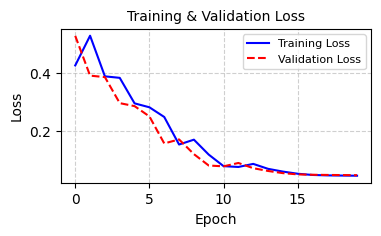

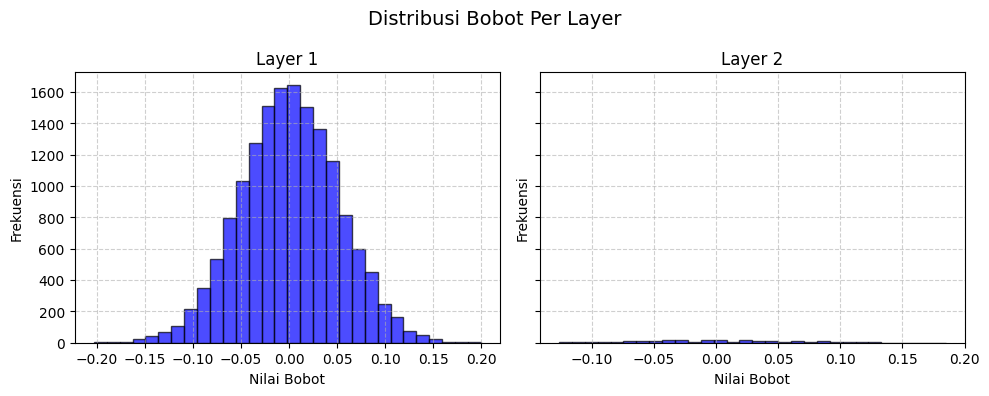

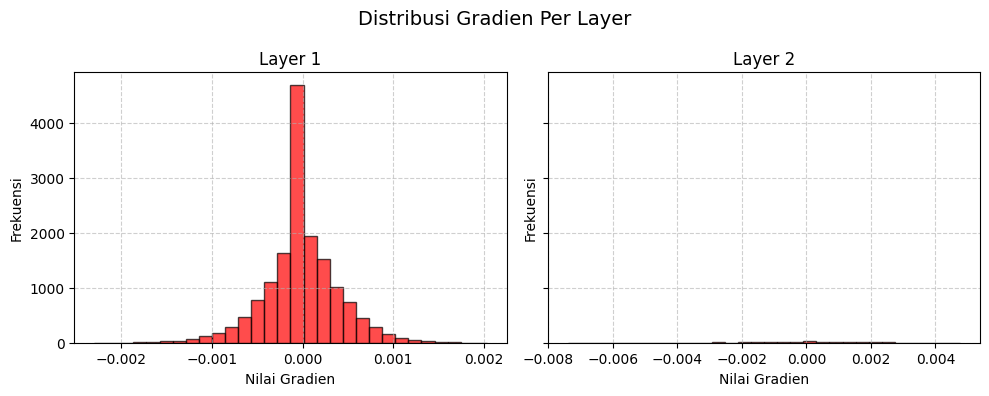

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.3810 - Validation Loss: 0.4194 - 1.50s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.425765  | 0.529849
    2 |  0.529853  | 0.370120
    3 |  0.369690  | 0.402736
    4 |  0.401821  | 0.312756
    5 |  0.309464  | 0.371958
    6 |  0.367675  | 0.326495
    7 |  0.331689  | 0.340631
    8 |  0.336993  | 0.390124
    9 |  0.393106  | 0.619489
   10 |  0.617231  | 0.561857
   11 |  0.563902  | 0.319586
   12 |  0.320134  | 0.277066
   13 |  0.273926  | 0.303498
   14 |  0.302941  | 0.410728
   15 |  0.412141  | 0.566483
   16 |  0.564330  | 0.606342
   17 |  0.608336  | 0.481696
   18 |  0.480579  | 0.649369
   19 |  0.646981  | 0.382059
   20 |  0.381010  | 0.419377


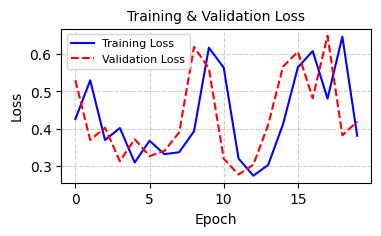

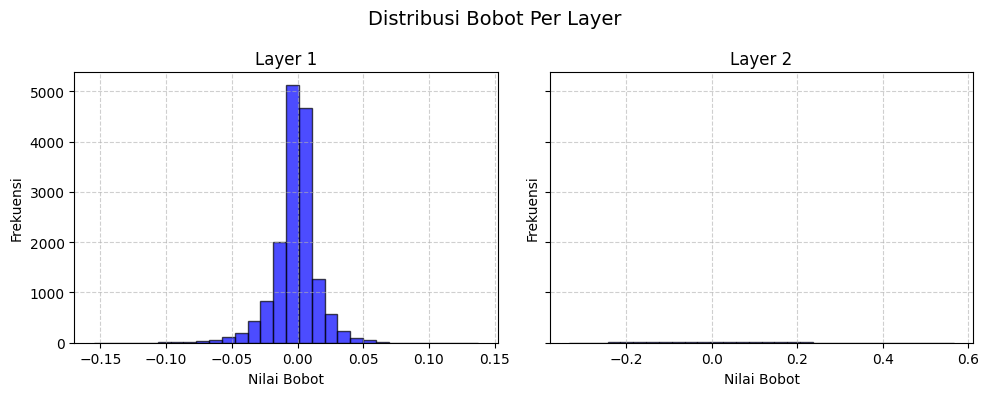

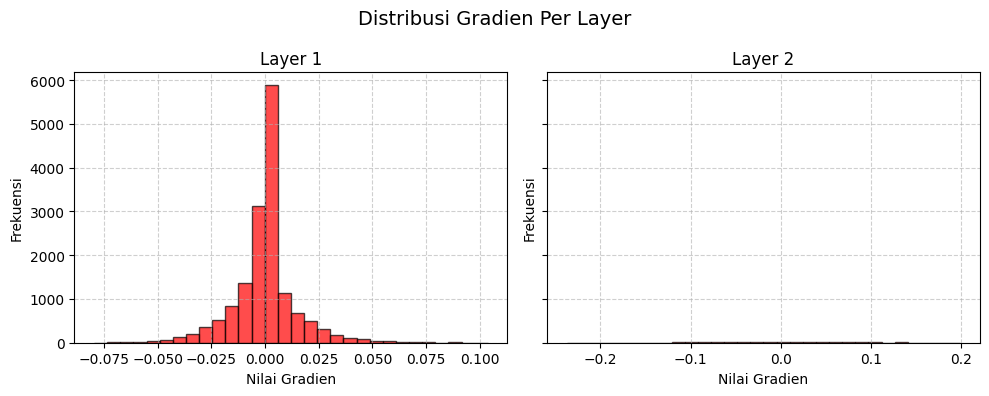

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.0428 - Validation Loss: 0.0444 - 1.50s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.425765  | 0.521850
    2 |  0.522210  | 0.376527
    3 |  0.374381  | 0.370709
    4 |  0.368439  | 0.274617
    5 |  0.273215  | 0.256868
    6 |  0.253767  | 0.218945
    7 |  0.216720  | 0.138471
    8 |  0.135401  | 0.151742
    9 |  0.152773  | 0.086298
   10 |  0.084115  | 0.093983
   11 |  0.093187  | 0.075839
   12 |  0.074969  | 0.067967
   13 |  0.066423  | 0.055744
   14 |  0.054037  | 0.050947
   15 |  0.049408  | 0.048305
   16 |  0.046491  | 0.046965
   17 |  0.045147  | 0.046011
   18 |  0.044105  | 0.045417
   19 |  0.043430  | 0.044814
   20 |  0.042769  | 0.044405


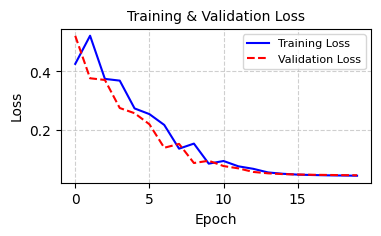

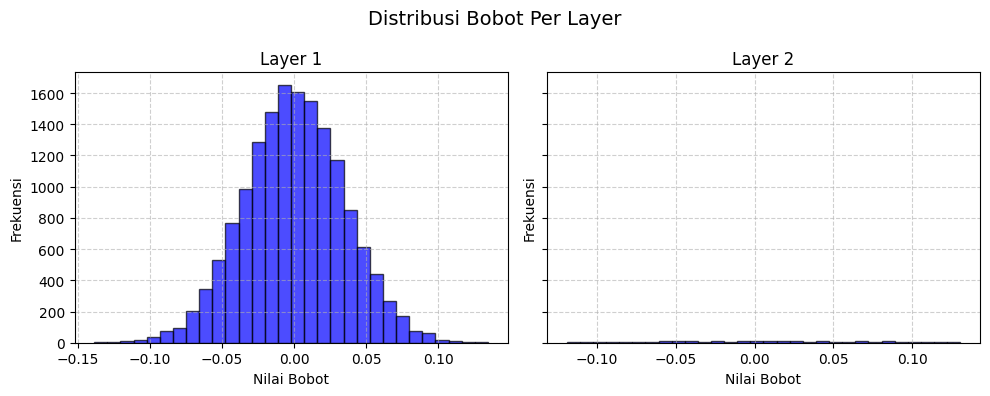

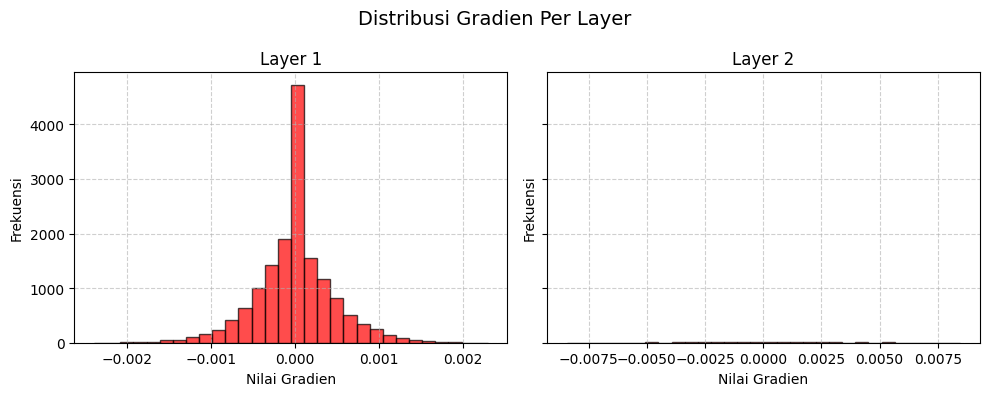

In [17]:
depth = 2
width = 20
learning_rate = 0.001
activation = tanh
weight_init = 'he'

ffnn, accuracy_ffnn = train_ffnn(depth=depth, width=width, learning_rate=learning_rate, activation=activation, weight_init=weight_init)

ffnn_l1, accuracy_ffnn_l1 = train_ffnn(depth=depth, width=width, learning_rate=learning_rate, activation=activation, weight_init=weight_init, regularization='l1')

ffnn_l2, accuracy_ffnn_l2 = train_ffnn(depth=depth, width=width, learning_rate=learning_rate, activation=activation, weight_init=weight_init, regularization='l2')


In [18]:
print(f"Akurasi Model FFNN tanpa regularisasi : {accuracy_ffnn:.2f}%")
print(f"Akurasi Model FFNN dengan regularisasi l1 : {accuracy_ffnn_l1:.2f}%")
print(f"Akurasi Model FFNN dengan regularisasi l2: {accuracy_ffnn_l2:.2f}%")

Akurasi Model FFNN tanpa regularisasi : 82.55%
Akurasi Model FFNN dengan regularisasi l1 : 21.49%
Akurasi Model FFNN dengan regularisasi l2: 83.63%


Model yang dijalankan dengan Regularisasi l2 memberikan nilai akurasi yang paling baik yaitu 83.63 %. Hal ini bisa ditinjau dari nilai validation loss terkecil yang diberikan diantara ketiganya yaitu di angka 0.044.
Jika ditinjau dari persebaran bobot per layernya persebaran untuk model tanpa regularisasi dan regularisasi l2 hampir mirip dan persebaran di sekitar 0 nya lebih sedikit <1700 sedangkan untuk regularisasi l1 >5000. Artinya, model ini akan mengupdate bobotnya tidak seperti regularisasi yang memberikan lebih banyak nilai bobot bernilai nol, yang menyebabkan model tidak melakukan pembelajaran karena backpropagation tidak berjalan.
Jika ditinjau dari persebaran gradien per layernya menunjukkan bahwa penggunaan regularisasi berpengaruh terhadap stabilitas pembelajaran dalam model. Pada model tanpa regularisasi, gradien di layer pertama terdistribusi merata dengan pusat di sekitar nol <5000, sementara layer kedua hampir tidak aktif. Saat regularisasi L1 diterapkan, distribusi gradien melebar dengan nilai-nilai ekstrem yang mulai muncul, dan persebaran berada di sekitaran nol yang mengartikan backpropagation tidak berjalan dengan baik mengindikasikan bahwa L1 mendorong sparsity namun juga dapat menyebabkan ketidakstabilan pada pembaruan bobot. Sementara itu, regularisasi L2 menghasilkan distribusi gradien yang merata dan nilai gradien nol nya lebih sedikit <5000, menandakan bahwa L2 lebih efektif dalam menjaga stabilitas pembelajaran dengan menekan nilai-nilai gradien ekstrem. Secara keseluruhan, L1 dan L2 memiliki efek berbeda dalam mengontrol skala gradien, di mana L2 cenderung memberikan hasil yang lebih stabil  dibandingkan tanpa regularisasi maupun L1.

### Pengaruh RMSNorm

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.0485 - Validation Loss: 0.0489 - 1.50s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.358051  | 0.432641
    2 |  0.432547  | 0.313025
    3 |  0.312197  | 0.333579
    4 |  0.331318  | 0.237307
    5 |  0.231833  | 0.271147
    6 |  0.263449  | 0.209541
    7 |  0.205193  | 0.220975
    8 |  0.213605  | 0.132430
    9 |  0.131030  | 0.184045
   10 |  0.183884  | 0.142037
   11 |  0.140517  | 0.169235
   12 |  0.167602  | 0.144507
   13 |  0.146449  | 0.114805
   14 |  0.114591  | 0.101174
   15 |  0.098608  | 0.071080
   16 |  0.068529  | 0.055855
   17 |  0.054313  | 0.052423
   18 |  0.050402  | 0.051540
   19 |  0.049726  | 0.050568
   20 |  0.048510  | 0.048941


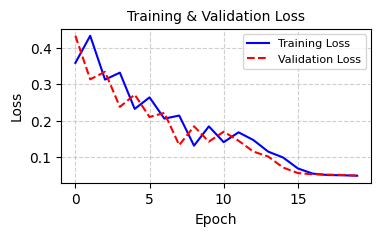

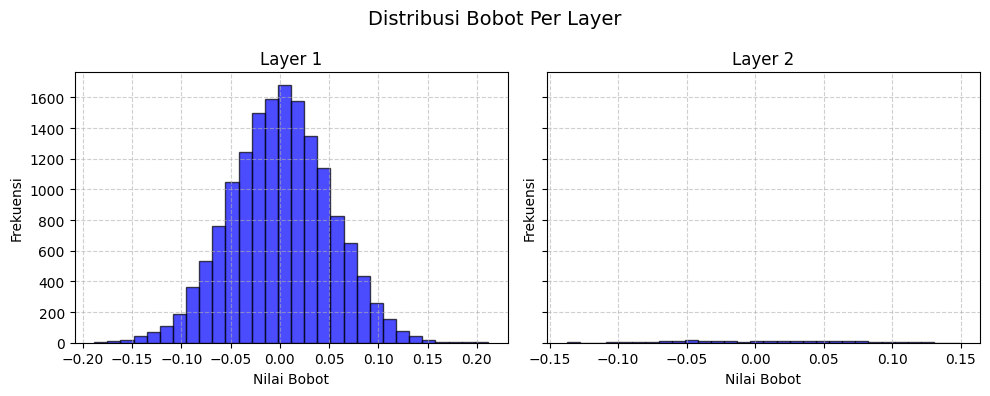

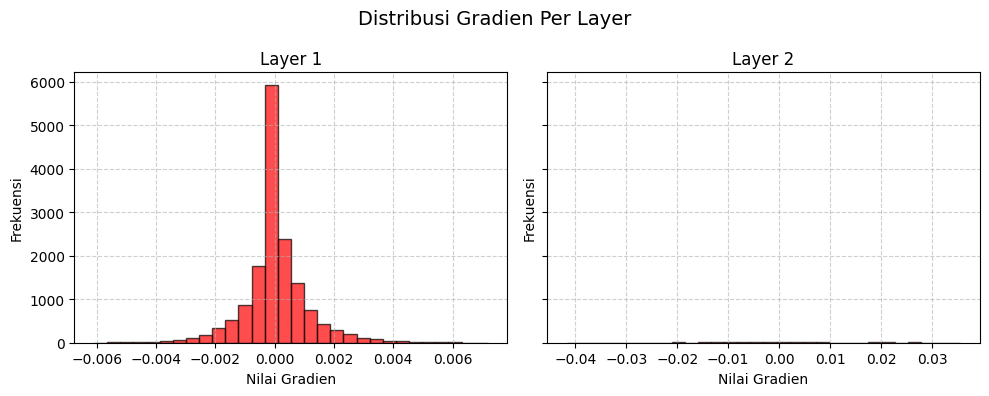

Epoch 20/20 [==============================] 100.0% - Training Loss: 0.9812 - Validation Loss: 0.6730 - 1.39s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  1.054928  | 0.338654
    2 |  0.921973  | 0.278527
    3 |  0.981581  | 0.320554
    4 |  0.985534  | 0.467233
    5 |  1.026886  | 0.336744
    6 |  0.939629  | 0.564736
    7 |  1.075973  | 0.452480
    8 |  1.017794  | 0.372775
    9 |  0.982815  | 0.398285
   10 |  0.965377  | 0.218848
   11 |  0.936629  | 0.312424
   12 |  1.070937  | 0.338237
   13 |  1.030759  | 0.384850
   14 |  0.983311  | 0.679902
   15 |  1.102903  | 0.373410
   16 |  0.918122  | 0.562078
   17 |  1.059338  | 0.253345
   18 |  0.886232  | 0.297060
   19 |  1.103671  | 0.320818
   20 |  0.981228  | 0.672971


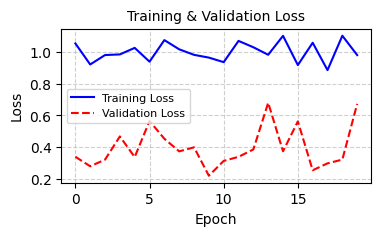

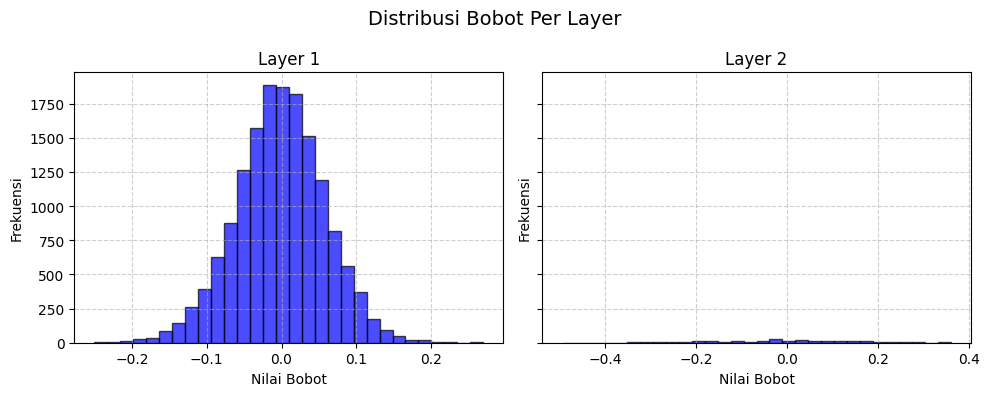

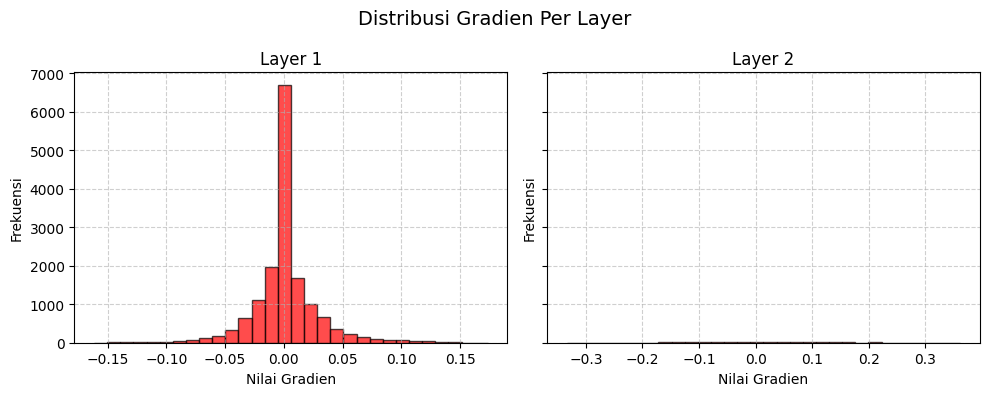

In [19]:
depth = 2
width = 20
learning_rate = 0.001
activation = tanh
weight_init = 'xavier'

ffnn, accuracy_ffnn = train_ffnn(depth=depth, width=width, learning_rate=learning_rate, activation=activation, weight_init=weight_init)

ffnn_norm, accuracy_ffnn_norm = train_ffnn(depth=depth, width=width, learning_rate=learning_rate, activation=activation, weight_init=weight_init, norm=True)

In [20]:
print(f"Akurasi Model FFNN tanpa normalisasi : {accuracy_ffnn:.2f}%")
print(f"Akurasi Model FFNN dengan normalisasi : {accuracy_ffnn_norm:.2f}%")

Akurasi Model FFNN tanpa normalisasi : 82.40%
Akurasi Model FFNN dengan normalisasi : 9.97%


Berdasarkan hasil pengujian dengan parameter yang sama, model FFNN tanpa normalisasi mencapai akurasi sebesar 82.40%, yang jauh lebih tinggi dibandingkan dengan penggunaan RMSNorm yang hanya mencatat 9.97%. Perbedaan ini kemungkinan besar disebabkan oleh ketidakcocokan normalisasi dengan fungsi aktivasi tanh dan inisialisasi bobot xavier. Hal ini terlihat dari grafik loss yang menunjukkan fluktuasi yang signifikan pada penggunaan normalisasi, yang menandakan adanya overfitting. Selain itu, distribusi bobot dan gradien pada lapisan yang lebih dalam menunjukkan persebaran nilai yang lebih luas, yang dapat mengakibatkan masalah exploding gradient dan berdampak negatif pada akurasi data.
